In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3


rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)

In [3]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [5]:
def get_Dataframe(path, name='Data'):
    Files = listdir(path) 
    #print (Files)
    df = None
    for f in Files:
        if name not in f: continue
        filename = path+f
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        for key in temp_file[name].keys():
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y",'gen_y',"e_*","gene*"], entrystop=3e6,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*","Q2","y","e_*"], entrystop=3e6,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    print('Dataframe has a total of ', df.shape[0], ' entries')
    print('####################################################################')

    return df


In [6]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [7]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('jet_px = jet_pt*cos(jet_phi)', inplace=True)
    temp.eval('jet_py = jet_pt*sin(jet_phi)', inplace=True)
    temp.eval('jet_qt = sqrt( (jet_px + e_px)**2 + (jet_py + e_py)**2) ', inplace=True)
    temp.eval('jet_qtnorm = jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('jet_phi = arctan(jet_py/jet_px)',inplace=True)
    temp.eval('jet_dphi = e_phi-jet_phi',inplace=True)
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)

    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt>7.0', 'jet pT > 7 GeV')


    if(isMC):
        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('genjet_px = genjet_pt*cos(genjet_phi)', inplace=True)
        temp.eval('genjet_py = genjet_pt*sin(genjet_phi)', inplace=True)
        temp.eval('genjet_qt = sqrt( (genjet_px + gene_px)**2 + (genjet_py + gene_py)**2) ', inplace=True)
        temp.eval('genjet_qtnorm = genjet_qt/sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_phi = arctan(gene_py/gene_px)', inplace=True)
        temp.eval('genjet_phi = arctan(genjet_py/genjet_px)',inplace=True)
        temp.eval('genjet_dphi = gene_phi-genjet_phi',inplace=True)
        
    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [8]:
path= '/data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/'

data = get_Dataframe(path, name='Data')
mc = get_Dataframe(path, name='Rapgap')
altmc = get_Dataframe(path, name='Django')

filename is /data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/Data_Eplus0304_2.root
filename is /data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/Data_Eplus0304_1.root
####################################################################
Dataframe has a total of  174361  entries
####################################################################
filename is /data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/Rapgap_Eplus0304_1.root
filename is /data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/Rapgap_Eplus0304_5.root
filename is /data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/Rapgap_Eplus0304_119.root
filename is /data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/Rapgap_Eplus0304_113.root
file has not minitree, skipping
filename is /data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/Rapgap_Eplus0304_105.root
filename is /data0/users/marratia/HERAdata/21-01-06-00-34-test17/out_ep0304/Rapgap_Epl

In [9]:
mc.keys()

Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'genjet_pt', 'genjet_phi',
       'genjet_eta', 'Q2', 'gen_Q2', 'y', 'gen_y', 'e_px', 'e_py', 'e_pz',
       'gene_px', 'gene_py', 'gene_pz'],
      dtype='object')

## Defining pass reco and pass truth variables

In [10]:
mc['pass_reco'] = np.where(mc['jet_pt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['jet_pt']>0, 1, 0)
altmc['pass_reco'] = np.where(altmc['jet_pt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['jet_pt']>0, 1, 0)
data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)

## Event selection

In [11]:
print('Selecting data events\n')
data = applyCutsJets(data)
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('alt mc')
altmc = applyCutsJets(altmc, isMC=True)

Selecting data events

0.2 < y < 0.7 103278  fraction kept: 59.2
Q2>150 79268  fraction kept: 76.8
jet pT > 7 GeV 53548  fraction kept: 67.6
Selecting MC events

0.2 < y < 0.7 5881696  fraction kept: 70.9
Q2>150 4953773  fraction kept: 84.2
jet pT > 7 GeV 4203190  fraction kept: 84.8
alt mc
0.2 < y < 0.7 5359809  fraction kept: 71.3
Q2>150 4401635  fraction kept: 82.1
jet pT > 7 GeV 3743602  fraction kept: 85.1


In [12]:
mc.head()

,,jet_pt,jet_phi,jet_eta,jet_dphi,genjet_pt,genjet_phi,genjet_eta,Q2,gen_Q2,y,...,e_phi,logQ2,gen_logQ2,gene_pt,genjet_px,genjet_py,genjet_qt,genjet_qtnorm,gene_phi,genjet_dphi
entry,subentry,,,,,,,,,,,,,,,,,,,,,
1,0,10.684989,0.727965,-0.106191,0.010093,14.682555,0.725339,-0.096391,399.713654,401.701111,0.288631,...,0.738057,2.601749,2.603903,16.515285,10.986582,9.740249,1.842391,0.091924,0.737439,0.012100
2,0,10.364684,0.797278,-0.579819,-0.341245,10.765827,0.793605,-0.583566,249.228073,261.412415,0.630669,...,0.456032,2.396597,2.417326,10.121972,-7.549860,-7.674805,3.553882,0.219806,0.457210,-0.336395
4,0,24.323441,0.919893,0.356466,0.035454,24.700481,0.923148,0.400747,1049.368286,1049.422241,0.390007,...,0.955347,3.020928,3.020951,25.446161,14.902109,19.698755,1.096419,0.033846,0.955211,0.032063
7,0,7.450256,-1.241152,-0.724615,2.707395,7.393727,-1.241417,-0.693020,263.045319,269.424133,0.355517,...,1.466244,2.420031,2.430437,13.165311,2.391542,-6.996265,7.160100,0.436215,1.467311,2.708729
8,0,18.350643,0.557239,0.106584,-0.045409,16.085825,0.467989,0.025204,456.435333,504.897430,0.429835,...,0.511830,2.659379,2.703203,18.081110,-14.356235,-7.256191,2.135305,0.095029,0.512586,0.044597


## Plot a few distributions at reco and truth level 

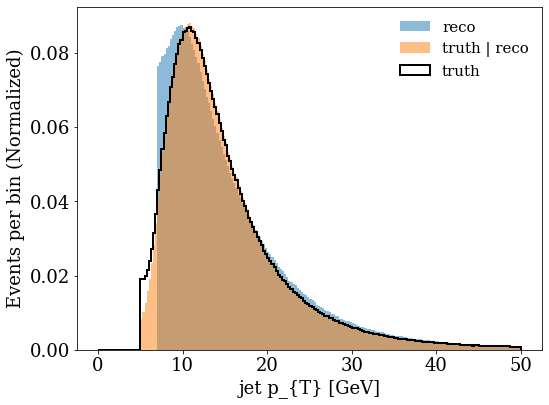

In [27]:
#plt.hist(mc.query('pass_reco==1')['e_pt'],range=(0,50),bins=200,**plot_style_2)

fig = plt.figure(figsize=(8,6))
plt.hist(mc.query('pass_reco==1')['jet_pt'],range=(0,50),bins=200,**plot_style_2,label='reco')
plt.hist(mc.query('pass_reco==1')['genjet_pt'],range=(0,50),bins=200,**plot_style_2, label='truth | reco')
plt.hist(mc['genjet_pt'],range=(0,50),bins=200,**plot_style_1, label='truth')
plt.xlabel('jet p_{T} [GeV]')
plt.ylabel('Events per bin (Normalized)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

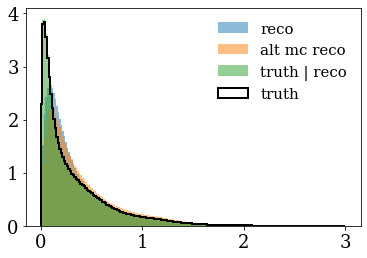

In [14]:
#plt.hist(mc.query('pass_reco==1')['e_pt'],range=(0,50),bins=200,**plot_style_2)
plt.hist(mc.query('pass_reco==1')['jet_qtnorm'],range=(0,3),bins=200,**plot_style_2,label='reco')
plt.hist(altmc.query('pass_reco==1')['jet_qtnorm'],range=(0,3),bins=200,**plot_style_2,label='alt mc reco')

plt.hist(mc.query('pass_reco==1')['genjet_qtnorm'],range=(0,3),bins=200,**plot_style_2, label='truth | reco')
plt.hist(mc['genjet_qtnorm'],range=(0,3),bins=200,**plot_style_1, label='truth')
plt.legend(loc='best')
plt.show()

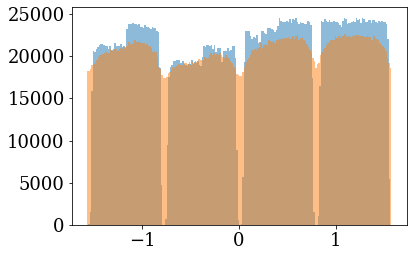

In [15]:
plt.hist(mc.query('pass_reco==1')['e_phi'],bins=200,alpha=0.5)
plt.hist(mc.query('pass_reco==1')['jet_phi'],bins=200,alpha=0.5)

#plt.hist(mc.query('pass_reco==1')['jet_phi'],bins=200,alpha=0.5)

plt.show()

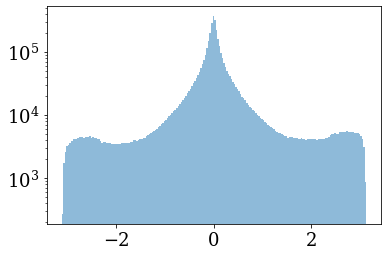

In [16]:
plt.hist(mc.query('pass_reco==1')['jet_dphi'],bins=200,alpha=0.5)
plt.yscale('log')
plt.show()



In [17]:
mc_cut = mc[:2000000]
altmc_cut = altmc[:200000]

In [18]:
print(len(data))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts
print(len(altmc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts


53548
1962132
2000000
196535


### Define UniFold Algorithm


In [19]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages

## Define features using just MC and alt MC *this is CLOSURE TEST*

In [20]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_G = altmc_cut['gene_px']
epx_unknown_S = altmc_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_G = altmc_cut['gene_py']
epy_unknown_S = altmc_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_G = altmc_cut['gene_pz']
epz_unknown_S = altmc_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_G = altmc_cut['genjet_pt']
jetpt_unknown_S = altmc_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_G = altmc_cut['genjet_phi']
jetphi_unknown_S = altmc_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_G = altmc_cut['genjet_eta']
jeteta_unknown_S = altmc_cut['jet_eta']


jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_G = altmc_cut['genjet_dphi']
jetdphi_unknown_S = altmc_cut['jet_dphi']


#jetqt_0_G       = np.log10(mc_cut['genjet_qtnorm'])
#jetqt_0_S       = np.log10(mc_cut['jet_qtnorm'])
#jetqt_unknown_G = np.log10(altmc_cut['genjet_qtnorm'])
#jetqt_unknown_S = np.log10(altmc_cut['jet_qtnorm'])

jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']
jetqt_unknown_G = altmc_cut['genjet_qt']
jetqt_unknown_S = altmc_cut['jet_qt']


In [21]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S)]
theta_unknown_G =np.c_[(epx_unknown_G, epy_unknown_G, epz_unknown_G, jetpt_unknown_G, jeteta_unknown_G, jetphi_unknown_G, jetdphi_unknown_G, jetqt_unknown_G)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]


In [22]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

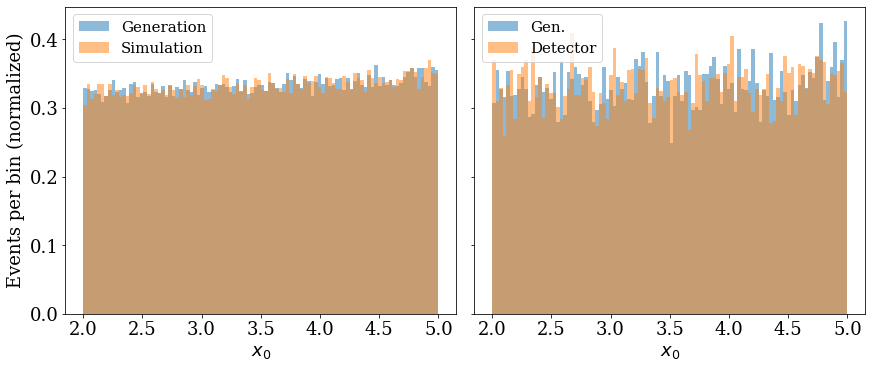

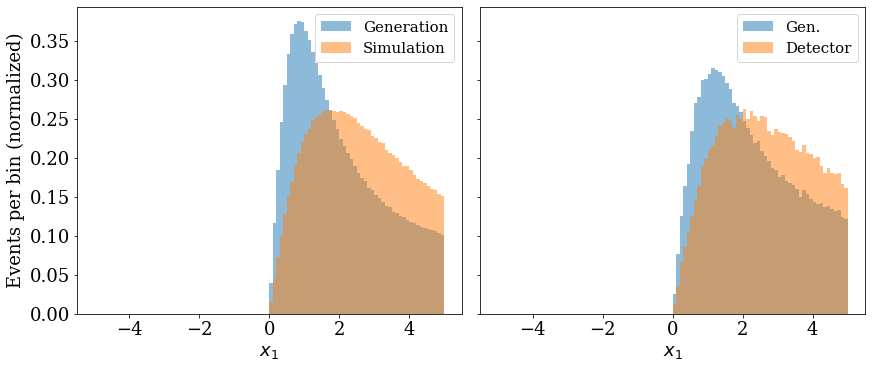

In [23]:
bins = np.linspace(2,5, 101)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_0$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_0$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)


ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,0], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

bins = np.linspace(-5,5, 101)
#bins = np.linspace(0,2, 101)
#bins = np.linspace(0,1,100)
fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x_1$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G[theta0_G[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    loc='best',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x_1$')

ax[1].hist(theta_unknown_G[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Gen.')
legend = ax[1].legend(
    loc='best',
    frameon=True)

ax[1].hist(theta_unknown_S[theta_unknown_S[:,0]!=-10][:,-1], bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    loc='best',
    frameon=True)






plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Define Multifold 

In [24]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S,verbose=1):
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    

    weights = np.empty(shape=(iterations, 2, len(theta0_G))) #this was 0
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))

    inputs = Input((num_observables, ))
     #inputs = Input((2, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                              verbose=verbose,
                              restore_best_weights=True)
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data (not MC weights)

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        #theta0_G[theta0_S[:,0]!=-10][:,1]
        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_1[X_train_1[:,0]!=-10],
              Y_train_1[X_train_1[:,0]!=-10],
              sample_weight=w_train_1[X_train_1[:,0]!=-10],
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_1[X_test_1[:,0]!=-10], Y_test_1[X_test_1[:,0]!=-10], w_test_1[X_test_1[:,0]!=-10]),
              callbacks=[earlystopping],
              verbose=verbose)

        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1. #these are events that don't pass reco; take the prior.
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
        model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=10000,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=verbose)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_push
    return weights, model

## Unfold

In [25]:
K.clear_session()

In [26]:
iterations = 4# use ~4 iterations
num_observables= 8

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)


ITERATION: 1

STEP 1

Train on 1621604 samples, validate on 540528 samples
Epoch 1/200
1621604/1621604 [==============================] - 4s 3us/step - loss: 0.3364 - acc: 0.9076 - val_loss: 0.3347 - val_acc: 0.9070
Epoch 2/200
1621604/1621604 [==============================] - 2s 1us/step - loss: 0.3306 - acc: 0.9077 - val_loss: 0.3326 - val_acc: 0.9070
Epoch 3/200
1621604/1621604 [==============================] - 2s 1us/step - loss: 0.3297 - acc: 0.9077 - val_loss: 0.3319 - val_acc: 0.9070
Epoch 4/200
1621604/1621604 [==============================] - 2s 1us/step - loss: 0.3291 - acc: 0.9077 - val_loss: 0.3317 - val_acc: 0.9070
Epoch 5/200
1621604/1621604 [==============================] - 2s 1us/step - loss: 0.3289 - acc: 0.9077 - val_loss: 0.3323 - val_acc: 0.9070
Epoch 6/200
1621604/1621604 [==============================] - 2s 1us/step - loss: 0.3288 - acc: 0.9077 - val_loss: 0.3314 - val_acc: 0.9070
Epoch 7/200
1621604/1621604 [==============================] - 2s 1us/step - l

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide



STEP 2

Train on 3000000 samples, validate on 1000000 samples
Epoch 1/200
3000000/3000000 [==============================] - 4s 1us/step - loss: 0.1817 - acc: 0.4998 - val_loss: 0.1802 - val_acc: 0.5006
Epoch 2/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1801 - acc: 0.4998 - val_loss: 0.1795 - val_acc: 0.5007
Epoch 3/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1797 - acc: 0.4997 - val_loss: 0.1792 - val_acc: 0.5006
Epoch 4/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1793 - acc: 0.4998 - val_loss: 0.1789 - val_acc: 0.5006
Epoch 5/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1791 - acc: 0.4998 - val_loss: 0.1788 - val_acc: 0.5006
Epoch 6/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1789 - acc: 0.4998 - val_loss: 0.1785 - val_acc: 0.5005
Epoch 7/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1787 -

3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1773 - acc: 0.4998 - val_loss: 0.1771 - val_acc: 0.5003
Epoch 59/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1773 - acc: 0.4998 - val_loss: 0.1771 - val_acc: 0.5004
Epoch 60/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1773 - acc: 0.4998 - val_loss: 0.1772 - val_acc: 0.5005
Epoch 61/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1773 - acc: 0.4998 - val_loss: 0.1771 - val_acc: 0.5004
Epoch 62/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1773 - acc: 0.4998 - val_loss: 0.1771 - val_acc: 0.5004
Epoch 63/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1773 - acc: 0.4998 - val_loss: 0.1772 - val_acc: 0.5003
Epoch 64/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1772 - acc: 0.4999 - val_loss: 0.1771 - val_acc: 0.5003
Epoch 65/200
300000

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply



STEP 2

Train on 3000000 samples, validate on 1000000 samples
Epoch 1/200
3000000/3000000 [==============================] - 4s 1us/step - loss: 0.1885 - acc: 0.5000 - val_loss: 0.1805 - val_acc: 0.5000
Epoch 2/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1802 - acc: 0.5000 - val_loss: 0.1798 - val_acc: 0.5000
Epoch 3/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1798 - acc: 0.5000 - val_loss: 0.1796 - val_acc: 0.5001
Epoch 4/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1795 - acc: 0.5000 - val_loss: 0.1793 - val_acc: 0.5001
Epoch 5/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1794 - acc: 0.5000 - val_loss: 0.1792 - val_acc: 0.5001
Epoch 6/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1792 - acc: 0.4999 - val_loss: 0.1791 - val_acc: 0.5000
Epoch 7/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1792 -

3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1787 - acc: 0.5000 - val_loss: 0.1789 - val_acc: 0.4999
Restoring model weights from the end of the best epoch
Epoch 00058: early stopping

ITERATION: 3

STEP 1

Train on 1621690 samples, validate on 540442 samples
Epoch 1/200
1621690/1621690 [==============================] - 2s 1us/step - loss: 0.1332 - acc: 0.6128 - val_loss: 0.1271 - val_acc: 0.5916
Epoch 2/200
1621690/1621690 [==============================] - 2s 1us/step - loss: 0.1271 - acc: 0.5879 - val_loss: 0.1270 - val_acc: 0.5247
Epoch 3/200
1621690/1621690 [==============================] - 2s 1us/step - loss: 0.1270 - acc: 0.5767 - val_loss: 0.1269 - val_acc: 0.5584
Epoch 4/200
1621690/1621690 [==============================] - 2s 1us/step - loss: 0.1269 - acc: 0.5757 - val_loss: 0.1269 - val_acc: 0.5975
Epoch 5/200
1621690/1621690 [==============================] - 2s 1us/step - loss: 0.1269 - acc: 0.5672 - val_loss: 0.1268 - val_acc: 0.5551
Epoch 6

Epoch 9/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1780 - acc: 0.5001 - val_loss: 0.1787 - val_acc: 0.4995
Epoch 10/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1780 - acc: 0.5001 - val_loss: 0.1781 - val_acc: 0.4993
Epoch 11/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1780 - acc: 0.5001 - val_loss: 0.1780 - val_acc: 0.4994
Epoch 12/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1780 - acc: 0.5001 - val_loss: 0.1782 - val_acc: 0.4994
Epoch 13/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1780 - acc: 0.5002 - val_loss: 0.1782 - val_acc: 0.4995
Epoch 14/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1780 - acc: 0.5002 - val_loss: 0.1780 - val_acc: 0.4995
Epoch 15/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1780 - acc: 0.5002 - val_loss: 0.1779 - val_acc: 0.4993
Epoch 1

3000000/3000000 [==============================] - 4s 1us/step - loss: 0.1867 - acc: 0.4997 - val_loss: 0.1776 - val_acc: 0.5008
Epoch 2/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1777 - acc: 0.4997 - val_loss: 0.1773 - val_acc: 0.5007
Epoch 3/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1775 - acc: 0.4997 - val_loss: 0.1772 - val_acc: 0.5008
Epoch 4/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1774 - acc: 0.4997 - val_loss: 0.1773 - val_acc: 0.5006
Epoch 5/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1774 - acc: 0.4997 - val_loss: 0.1771 - val_acc: 0.5006
Epoch 6/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1774 - acc: 0.4997 - val_loss: 0.1771 - val_acc: 0.5006
Epoch 7/200
3000000/3000000 [==============================] - 3s 1us/step - loss: 0.1774 - acc: 0.4997 - val_loss: 0.1771 - val_acc: 0.5006
Epoch 8/200
3000000/30000

## Put weights into MC dataframe

In [28]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Check that weights are reasonable

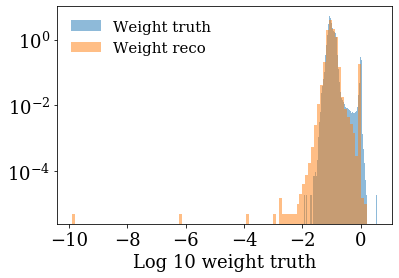

6.4255805015563965
0.00020158693951088935
1.0
0.0019007055088877678
 
82.8349380493164
4.650398295780178e-06
1.0
3.512862463139754e-07
 
1.9091267585754395
2.2769495444663335e-06
1.2659552097320557
2.493963608917792e-18
 
3.5614728927612305
0.006327690556645393
1.6812412738800049
1.335889177056515e-10
 


In [29]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Remove some large weights 

In [31]:
print(len(mc_cut))
mc_cut.query('weight_truth>10000')
print(len(mc_cut.query(' weight_reco>0.01')))

mc_cut = mc_cut.query('weight_reco<100 and weight_reco>0.01')
#altmc_cut = altmc_cut.query('weight_truth<10000')
print(len(mc_cut))

mc_cut = mc_cut.query('weight_truth<100 and weight_truth>0.01')
print(len(mc_cut))

1999982
1999982
1999982
1999982


## Closure Test

The query is: pass_reco==1 and gen_y>0.2 and gen_y<0.7 and gen_Q2>150 and genjet_pt>10
ITERATION: 3
ITERATION: 4


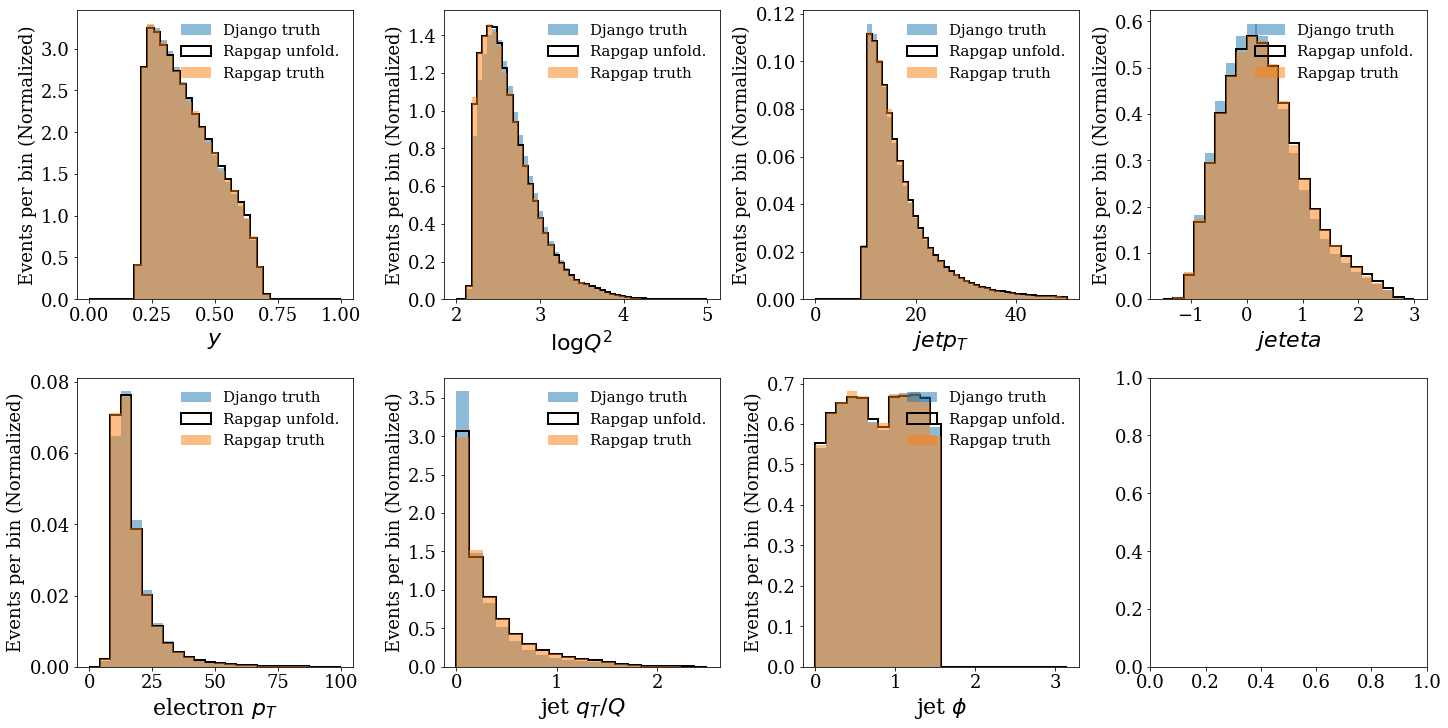

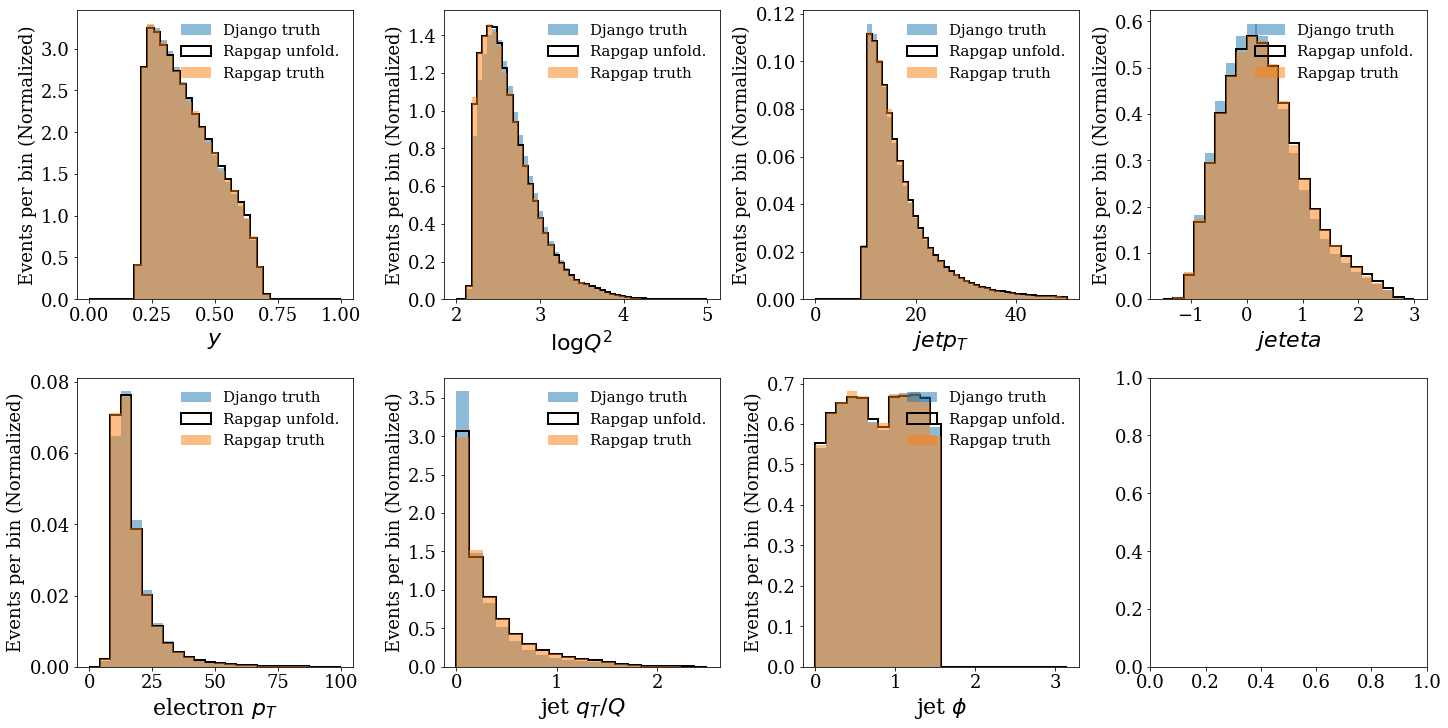

In [33]:
event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
#track_selection = 'gen_track_pt>0.2'
jet_selection    = 'genjet_pt>10'
query = 'pass_reco==1 and ' + event_selection + ' and ' + jet_selection
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Rapgap unfold.'
label3 = r'Rapgap truth'


for i in range(len(weights)):
    if(i<2): continue
    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(altmc_cut.query(query)['gen_y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False)

    bins = np.linspace(2, 5,50 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(altmc_cut.query(query)['gen_logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,1].legend(frameon=False)

    

    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(altmc_cut.query(query)['genjet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,2].legend(frameon=False)


    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'], bins=bins, label=label1, **plot_style_2)
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(altmc_cut.query(query)['genjet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,3].legend(frameon=False)

    bins = np.linspace(0,100,25)

    ax[1,0].set_xlabel(r'electron $p_{T}$',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(altmc_cut.query(query)['gene_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[1,0].legend(frameon=False,loc='best')
    
    
    
    bins = np.linspace(0,2.5,20)

    ax[1,1].set_xlabel(r'jet $q_{T}/Q$',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['genjet_qtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(altmc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[1,1].legend(frameon=False,loc='best')
    
    
    
    bins = np.linspace(0,np.pi,25)

    ax[1,2].set_xlabel(r'jet $\phi$',fontsize=22)
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(mc_cut.query(query)['genjet_phi'], bins=bins, label=label1, **plot_style_2)
    ax[1,2].hist(mc_cut.query(query)['genjet_phi'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,2].hist(altmc_cut.query(query)['genjet_phi'],
               bins=bins,
               label=label3,
               **plot_style_2)
    ax[1,2].legend(frameon=False,loc='best')
    


    #fig.savefig('figures/Closure_HadronInJet_%i_iter.png'%i)    

## Show the reweighting of the reco

The query is: pass_reco==1 
ITERATION: 3
ITERATION: 4


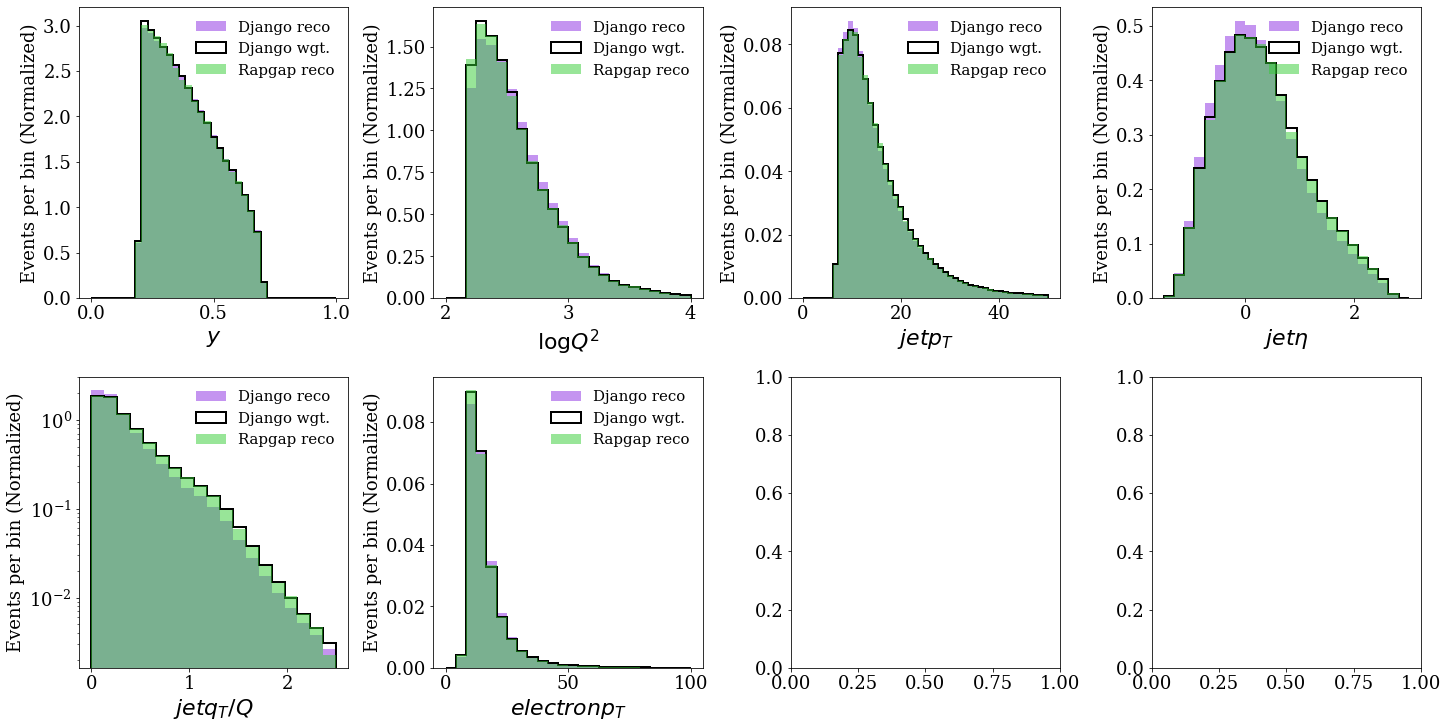

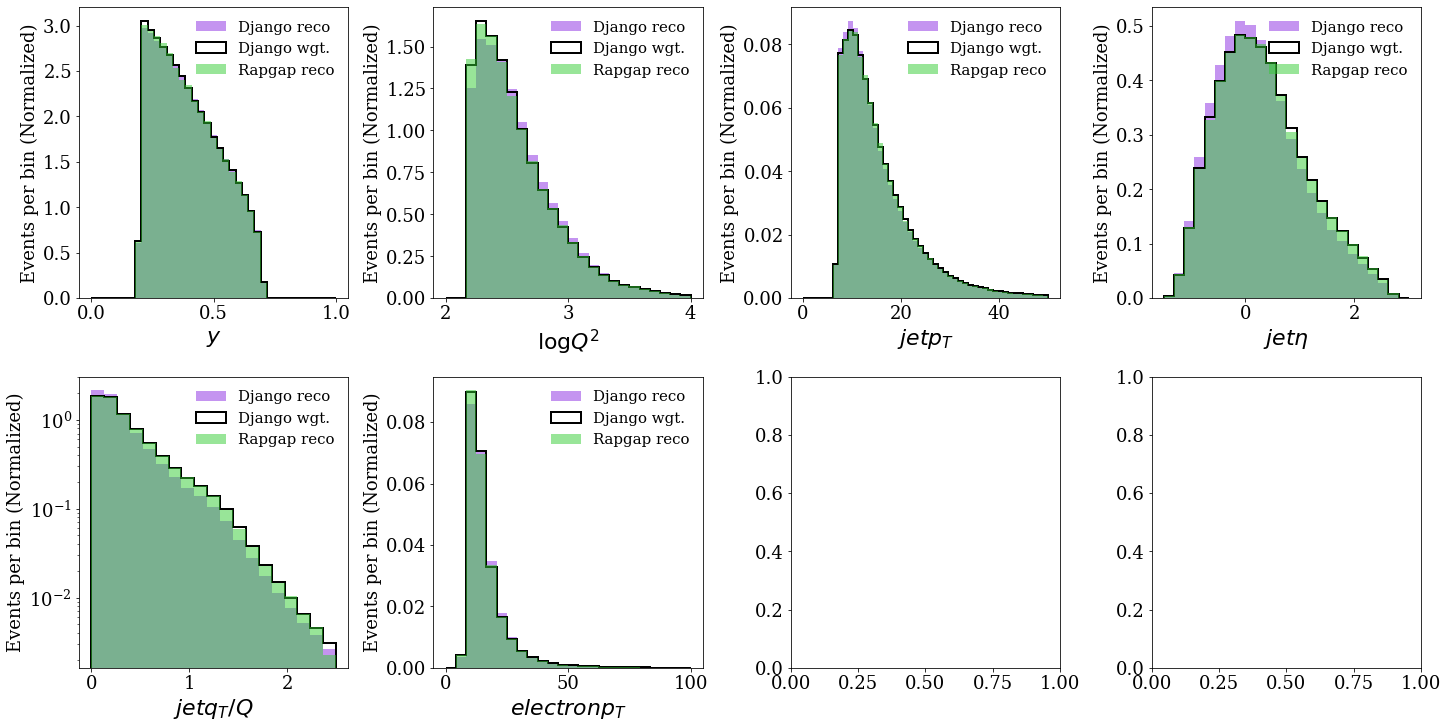

In [34]:
query = 'pass_reco==1 '
print('The query is:' , query)
label1 = r'Django reco'
label2 = r'Django wgt.'
label3 = r'Rapgap reco'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):
    if(i<2): continue

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(altmc_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(altmc_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,1].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$ jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(altmc_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[0,2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet \eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['jet_eta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(altmc_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[0,3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,20)
    
    ax[1,0].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(altmc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1,0].legend(frameon=False,loc='best')
    ax[1,0].set_yscale('log')

   
    bins = np.linspace(0,100,25)

    ax[1,1].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,1].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(altmc_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[1,1].legend(frameon=False,loc='best')
    
    #plt.tight_layout()
    #fig.savefig('figures/Closure_3_HadronInJet_%i_iter.png'%i)  
    
    

## Closure for differential plots

 gen_Q2 > 150.00 and gen_Q2 <500.00 and gen_y>0.2 and gen_y<0.7 and genjet_pt>15
###########
 gen_Q2 > 500.00 and gen_Q2 <1000.00 and gen_y>0.2 and gen_y<0.7 and genjet_pt>15
###########
 gen_Q2 > 1000.00 and gen_Q2 <10000.00 and gen_y>0.2 and gen_y<0.7 and genjet_pt>15
###########


Text(0, 0.5, 'Normalized entries')

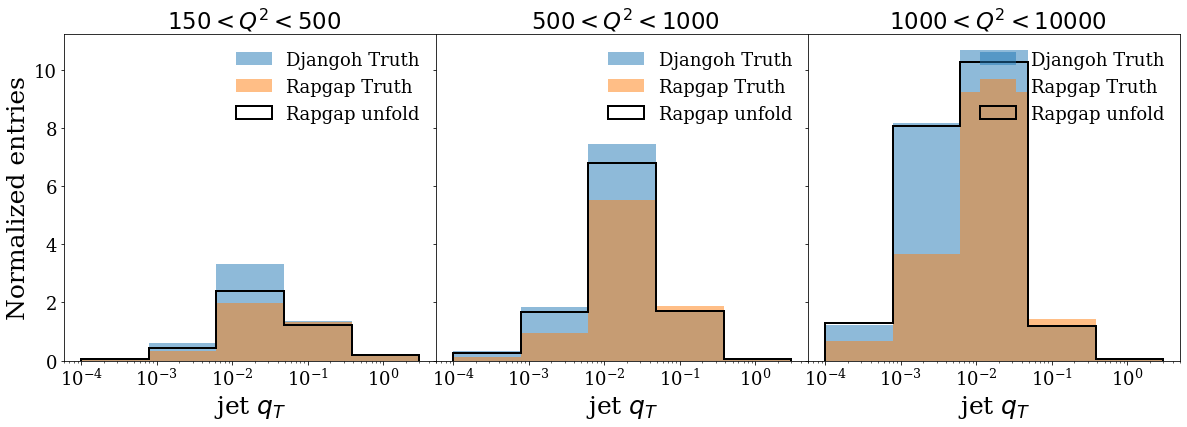

In [35]:
#bins = np.logspace(np.log10(0.01),np.log10(3),8)
bins = np.logspace(np.log10(0.0001), np.log10(3),6)

fig, axs = plt.subplots(1, 3,sharey=True, figsize=(20,6), gridspec_kw={'wspace':0, 'hspace':0})

for counter,edges in enumerate([(150,500), (500,1000),(1000,10000)]):
    cut = ' gen_Q2 > %2.2f and gen_Q2 <%2.2f and gen_y>0.2 and gen_y<0.7'%(edges[0],edges[1])
    cut = cut + ' and genjet_pt>15'
    #cut = cut + ' and pass_reco==1'
    print (cut)
    #df_cut = df.query(cut)
    #printSummary(df_cut)
    print ('###########')
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)
    axs[counter].xaxis.set_label_text('jet $q_{T}$', fontsize=25)

    ##Plot data
    #Nelectrons = df.query(cut).shape[0]
   # axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['track_jt'],weights=mc_cut.query(cut+'and pass_reco==1')['weight_reco'],bins=bins,alpha=0.9,density=True, 
   #                  label='MC wgt to data reco',color='blue',lw=3,histtype='step')

    #axs[counter].hist(mc_cut.query(cut+'and pass_reco==1')['gen_track_jt'],bins=bins,weights=mc_cut.query(cut+'and pass_reco==1')['weight_truth'],label = 'Unfolded',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Djangoh Truth',**plot_style_2)
    axs[counter].hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Rapgap Truth',**plot_style_2)
    axs[counter].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)

    axs[counter].legend(prop={'size': 18}, frameon=False, loc='best')
    axs[counter].set_title(' $ %2.0f< Q^{2} < %2.0f$'%(edges[0],edges[1]))


    #axs[counter].text(1.5,2.9,  r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(data_cut.query(cut)['x'].mean(), data_cut.query(cut)['Q2'].mean()), fontsize=18)
    #axs[counter].set_yscale('log')
    axs[counter].set_xscale('log')

 
axs[0].yaxis.set_label_text('Normalized entries', fontsize=25)


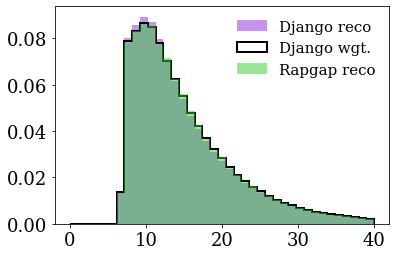

In [36]:
bins = np.linspace(0,40,40 )
query = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'

#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

plt.hist(altmc_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    #ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
plt.legend(frameon=False,loc='best')

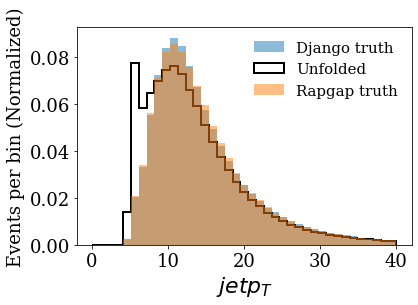

In [37]:
query = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'

plt.hist(mc_cut.query(query)['genjet_pt'], bins=bins, label='Django truth', **plot_style_2)
plt.hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label='Unfolded',
               **plot_style_1)

plt.hist(altmc_cut.query(query)['genjet_pt'],
               bins=bins,
               label='Rapgap truth',
               **plot_style_2)

plt.xlabel(r'$jet p_{T} $',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
plt.legend(frameon=False)

## Closure Test  jet pT spectrum

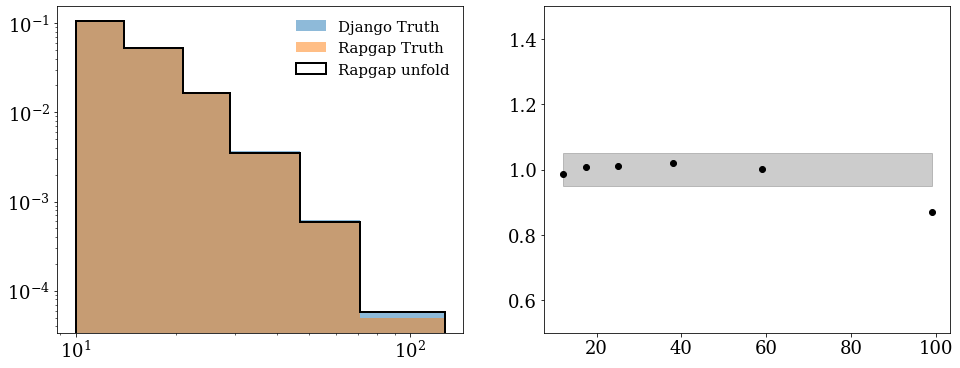

In [39]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
#bins = np.logspace(np.log10(15),np.log10(100),8)
bins = np.array([10,14,21,29,47,71,127])

ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label='Django Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label='Rapgap Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xscale('log')


ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

plt.show()

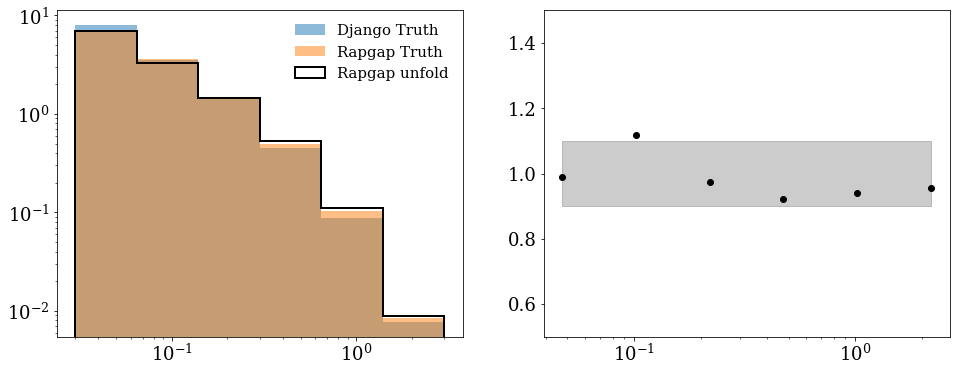

In [40]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 300 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>15'
#bins = np.linspace(0,3,6)
bins = np.logspace(np.log10(0.03),np.log10(3),7)
ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Django Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Rapgap Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_yscale('log')

ax[0].set_xscale('log')
ax[1].set_xscale('log')


ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.9,1.1,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

plt.show()

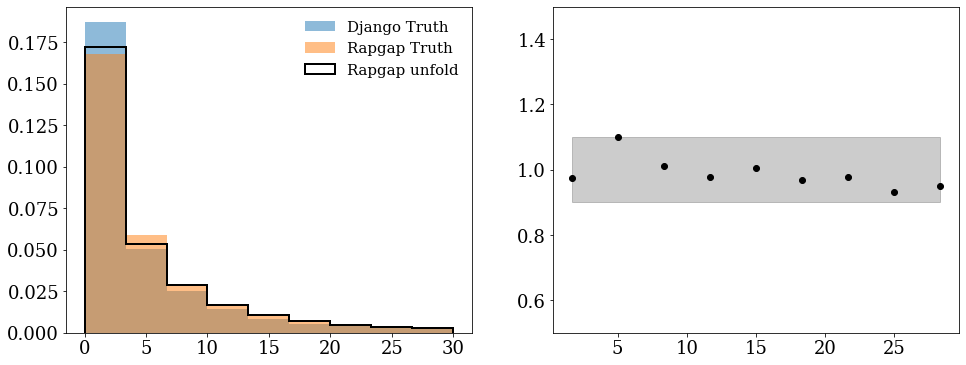

In [41]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 300 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>15'

bins = np.linspace(0,30,10)
#bins = np.logspace(np.log10(0.01),np.log10(30),7)
ax[0].hist(mc_cut.query(cut)['genjet_qt'],bins=bins,label='Django Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_qt'],bins=bins,label='Rapgap Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_qt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')
#ax[1].set_xscale('log')


ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.9,1.1,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

plt.show()

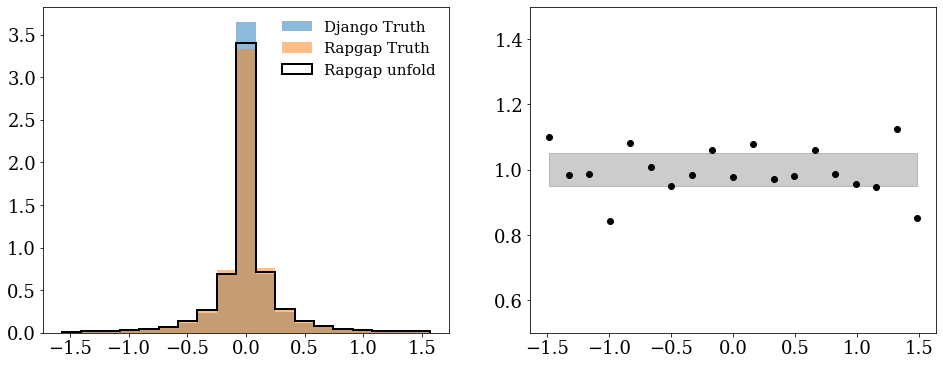

In [42]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 300 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>15'# and genjet_pt<20 '
bins = np.linspace(-np.pi/2.0,np.pi/2.0,20) 
ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,label='Django Truth',**plot_style_2)

num,x,_ = ax[0].hist(altmc_cut.query(cut)['genjet_dphi'],bins=bins,label='Rapgap Truth',**plot_style_2)
den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_dphi'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Rapgap unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
#ax[0].set_yscale('log')
#ax[0].set_xscale('log')


ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.95,1.05,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

plt.show()

## check weights

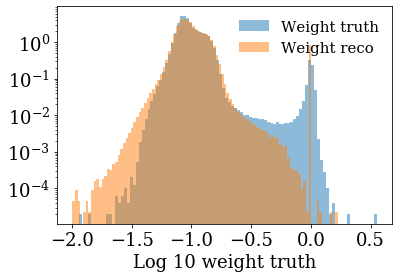

6.4255805015563965
0.00020158693951088935
1.0
0.0019007055088877678
 
82.8349380493164
4.650398295780178e-06
1.0
3.512862463139754e-07
 
1.9091267585754395
2.2769495444663335e-06
1.2659552097320557
2.493963608917792e-18
 
3.5614728927612305
0.006327690556645393
1.6812412738800049
1.335889177056515e-10
 


In [43]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))
    print(max(weights[i, 0, :]))
    print(min(weights[i, 0, :]))
    print(' ')

## Compute some efficiency

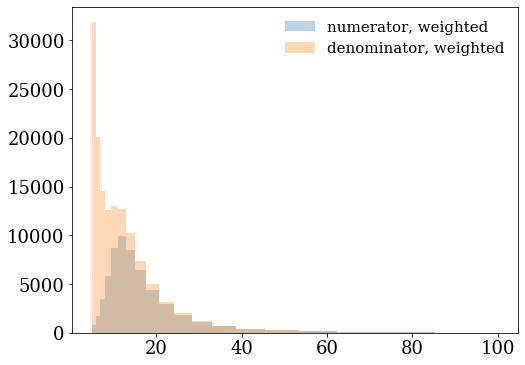

In [85]:
fig= plt.figure(figsize=(8,6))
bins = np.logspace(np.log10(5),np.log10(100),20)
num,x,_  = plt.hist(mc_cut.query('pass_reco==1')['genjet_pt'], weights=mc_cut.query('pass_reco==1')['weight_truth'],bins=bins,label='numerator, weighted',alpha=0.3)
den,x,_  = plt.hist(mc_cut['genjet_pt'], weights=mc_cut['weight_truth'],bins=bins,label='denominator, weighted',alpha=0.3)
x= (x[1:] + x[:-1])/2.0

plt.legend()
plt.show()
eff_weighted= np.true_divide(num,den)

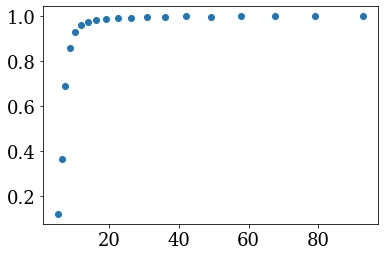

In [45]:
plt.plot(x,eff_weighted,'o')
#plt.xscale('log')

In [46]:
K.clear_session()

## Define features with data

In [47]:
mc_cut = mc#[:1000000]
altmc_cut = altmc#[:1000000]
data_cut = data#[:50000]

print(len(mc_cut))
print(len(data_cut))

4203190
53548


In [48]:
#mc_cut = pd.concat([mc_cut, altmc_cut])

In [49]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


53548
4123337
4203190


In [50]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']
epx_unknown_S = data_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']
epy_unknown_S = data_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']
epz_unknown_S = data_cut['e_pz']


jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']
jetphi_unknown_S = data_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']
jetdphi_unknown_S = data_cut['jet_dphi']


#jetqt_0_G       = mc_cut['genjet_qtnorm'])
#jetqt_0_S       = np.log10(mc_cut['jet_qtnorm'])
#jetqt_unknown_S = np.log10(data_cut['jet_qtnorm'])
jetqt_0_G       = mc_cut['genjet_qt']
jetqt_0_S       = mc_cut['jet_qt']
jetqt_unknown_S = data_cut['jet_qt']



In [51]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S)]
theta_unknown_G =np.c_[(epx_unknown_G, epy_unknown_G, epz_unknown_G, jetpt_unknown_G, jeteta_unknown_G, jetphi_unknown_G, jetdphi_unknown_G, jetqt_unknown_G)]
theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]


In [52]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [53]:
print(len(data_cut))
print(len(mc_cut.query('pass_reco==1'))) ##only what is really reconstructed counts
print(len(mc_cut)) ##only what is really reconstructed counts


53548
4123337
4203190


## Run unfolding on data

In [54]:
K.clear_session()

In [55]:
iterations = 4# use ~4 iterations
num_observables= 8

weights, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S)


ITERATION: 1

STEP 1

Train on 3132619 samples, validate on 1044266 samples
Epoch 1/200
3132619/3132619 [==============================] - 4s 1us/step - loss: 0.0890 - acc: 0.9812 - val_loss: 0.0729 - val_acc: 0.9873
Epoch 2/200
3132619/3132619 [==============================] - 4s 1us/step - loss: 0.0721 - acc: 0.9871 - val_loss: 0.0705 - val_acc: 0.9873
Epoch 3/200
3132619/3132619 [==============================] - 3s 1us/step - loss: 0.0705 - acc: 0.9871 - val_loss: 0.0694 - val_acc: 0.9873
Epoch 4/200
3132619/3132619 [==============================] - 4s 1us/step - loss: 0.0696 - acc: 0.9871 - val_loss: 0.0688 - val_acc: 0.9873
Epoch 5/200
3132619/3132619 [==============================] - 3s 1us/step - loss: 0.0691 - acc: 0.9871 - val_loss: 0.0682 - val_acc: 0.9873
Epoch 6/200
3132619/3132619 [==============================] - 4s 1us/step - loss: 0.0688 - acc: 0.9871 - val_loss: 0.0681 - val_acc: 0.9873
Epoch 7/200
3132619/3132619 [==============================] - 3s 1us/step - 

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide



STEP 2

Train on 6304785 samples, validate on 2101595 samples
Epoch 1/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0540 - acc: 0.5000 - val_loss: 0.0512 - val_acc: 0.4999
Epoch 2/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0507 - acc: 0.5000 - val_loss: 0.0499 - val_acc: 0.5000
Epoch 3/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0498 - acc: 0.5000 - val_loss: 0.0495 - val_acc: 0.4999
Epoch 4/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0492 - acc: 0.5000 - val_loss: 0.0491 - val_acc: 0.4999
Epoch 5/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0487 - acc: 0.5000 - val_loss: 0.0483 - val_acc: 0.4999
Epoch 6/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0485 - acc: 0.5000 - val_loss: 0.0484 - val_acc: 0.4998
Epoch 7/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0483 -

6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0473 - acc: 0.5000 - val_loss: 0.0470 - val_acc: 0.4999
Epoch 59/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0472 - acc: 0.5000 - val_loss: 0.0474 - val_acc: 0.4998
Restoring model weights from the end of the best epoch
Epoch 00059: early stopping

ITERATION: 2

STEP 1

Train on 3132853 samples, validate on 1044032 samples
Epoch 1/200
3132853/3132853 [==============================] - 4s 1us/step - loss: 0.0191 - acc: 0.5484 - val_loss: 0.0179 - val_acc: 0.5986
Epoch 2/200
3132853/3132853 [==============================] - 4s 1us/step - loss: 0.0178 - acc: 0.4830 - val_loss: 0.0178 - val_acc: 0.4072
Epoch 3/200
3132853/3132853 [==============================] - 4s 1us/step - loss: 0.0177 - acc: 0.4653 - val_loss: 0.0178 - val_acc: 0.4221
Epoch 4/200
3132853/3132853 [==============================] - 4s 1us/step - loss: 0.0177 - acc: 0.4547 - val_loss: 0.0178 - val_acc: 0.5296
Epoch

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: overflow encountered in multiply



STEP 2

Train on 6304785 samples, validate on 2101595 samples
Epoch 1/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0536 - acc: 0.4999 - val_loss: 0.0478 - val_acc: 0.5001
Epoch 2/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0477 - acc: 0.4999 - val_loss: 0.0476 - val_acc: 0.5001
Epoch 3/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0475 - acc: 0.4999 - val_loss: 0.0475 - val_acc: 0.5001
Epoch 4/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0475 - acc: 0.5000 - val_loss: 0.0474 - val_acc: 0.5001
Epoch 5/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0475 - acc: 0.5000 - val_loss: 0.0475 - val_acc: 0.5001
Epoch 6/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0475 - acc: 0.5000 - val_loss: 0.0474 - val_acc: 0.5000
Epoch 7/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0475 -

6304785/6304785 [==============================] - 8s 1us/step - loss: 0.0559 - acc: 0.4999 - val_loss: 0.0492 - val_acc: 0.5000
Epoch 2/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0491 - acc: 0.4999 - val_loss: 0.0488 - val_acc: 0.5000
Epoch 3/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0488 - acc: 0.5000 - val_loss: 0.0493 - val_acc: 0.5001
Epoch 4/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0487 - acc: 0.5000 - val_loss: 0.0485 - val_acc: 0.5000
Epoch 5/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0486 - acc: 0.5000 - val_loss: 0.0484 - val_acc: 0.5000
Epoch 6/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0486 - acc: 0.5000 - val_loss: 0.0484 - val_acc: 0.5000
Epoch 7/200
6304785/6304785 [==============================] - 7s 1us/step - loss: 0.0486 - acc: 0.4999 - val_loss: 0.0485 - val_acc: 0.5000
Epoch 8/200
6304785/63047

Epoch 25/200
3132841/3132841 [==============================] - 4s 1us/step - loss: 0.0182 - acc: 0.5839 - val_loss: 0.0182 - val_acc: 0.7607
Epoch 26/200
3132841/3132841 [==============================] - 4s 1us/step - loss: 0.0182 - acc: 0.5883 - val_loss: 0.0181 - val_acc: 0.4904
Epoch 27/200
3132841/3132841 [==============================] - 4s 1us/step - loss: 0.0182 - acc: 0.5821 - val_loss: 0.0181 - val_acc: 0.6152
Epoch 28/200
3132841/3132841 [==============================] - 4s 1us/step - loss: 0.0182 - acc: 0.5744 - val_loss: 0.0181 - val_acc: 0.5835
Epoch 29/200
3132841/3132841 [==============================] - 4s 1us/step - loss: 0.0182 - acc: 0.5821 - val_loss: 0.0182 - val_acc: 0.5654
Epoch 30/200
3132841/3132841 [==============================] - 4s 1us/step - loss: 0.0182 - acc: 0.5965 - val_loss: 0.0182 - val_acc: 0.3310
Epoch 31/200
3132841/3132841 [==============================] - 4s 1us/step - loss: 0.0182 - acc: 0.5773 - val_loss: 0.0181 - val_acc: 0.6038
Epoch 

## Incorporate weights into the dataframe

In [56]:
mc_cut['weight_reco'] = weights[-1, 0, :]
mc_cut['weight_truth'] = weights[-1, 1, :]

## Check weights

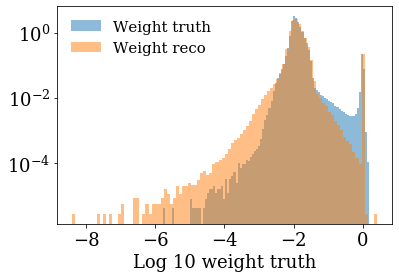

Iteration 0
2.0581166744232178 0.00026253360556438565
1.0 0.0005223075859248638
 
Iteration 1
12.925797462463379 1.3193188124205335e-06
5.539975643157959 6.1331451028934225e-09
 
Iteration 2
17.073755264282227 6.0315987866488285e-06
1.25473153591156 3.664764491873029e-08
 
Iteration 3
1.5385042428970337 1.7203093420903315e-06
2.505566120147705 4.0521004329718835e-09
 


In [57]:
plt.hist(np.log10(mc_cut['weight_truth']),bins=100,**plot_style_2,label='Weight truth')
plt.hist(np.log10(mc_cut['weight_reco']),bins=100,**plot_style_2, label='Weight reco')
plt.legend()
plt.xlabel('Log 10 weight truth')
plt.yscale('log')
plt.show()

for i in range(len(weights)):
    print ('Iteration %i'%i)
    print(max(weights[i, 1, :]), min(weights[i, 1, :]))    
    print(max(weights[i, 0, :]), min(weights[i, 0, :]))
    print(' ')

ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4


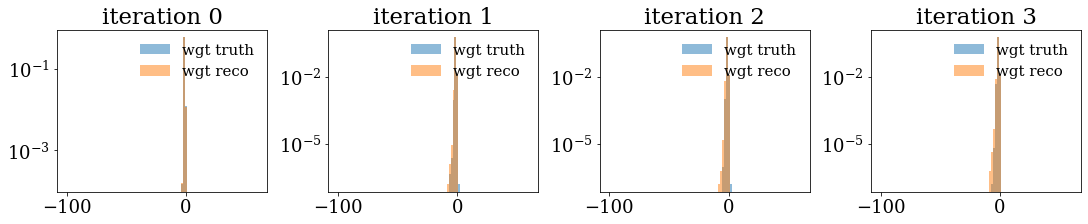

In [58]:
fig, ax = plt.subplots(1,
                           4,
                           figsize=(15, 3),
                           constrained_layout=True)
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    #bins = np.linspace(5, 50, 45)

    
    ax[i].hist(np.log10(weights[i, 1, :][~np.isnan(weights[i, 1, :])]),bins=100,range=(-100,60),**plot_style_2,label='wgt truth')
    ax[i].hist(np.log10(weights[i, 0, :][~np.isnan(weights[i, 0, :])]),bins=100,range=(-100,60),**plot_style_2, label='wgt reco') 
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_title('iteration %i'%i)

    #ax[i].xlabel('Log 10 weight truth')

## Incorporate weights into the dataframe

## MC at reco level reweighted vs data

The query is: pass_reco==1 
ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4


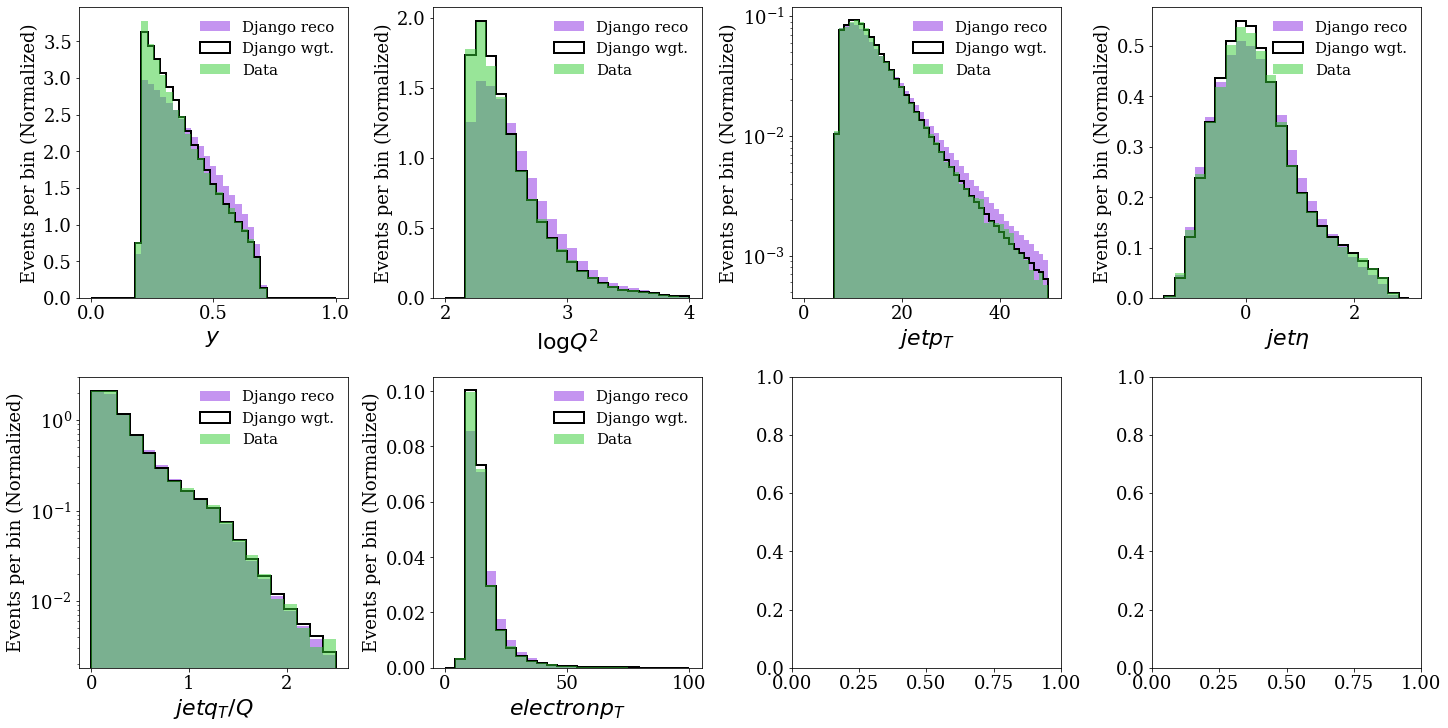

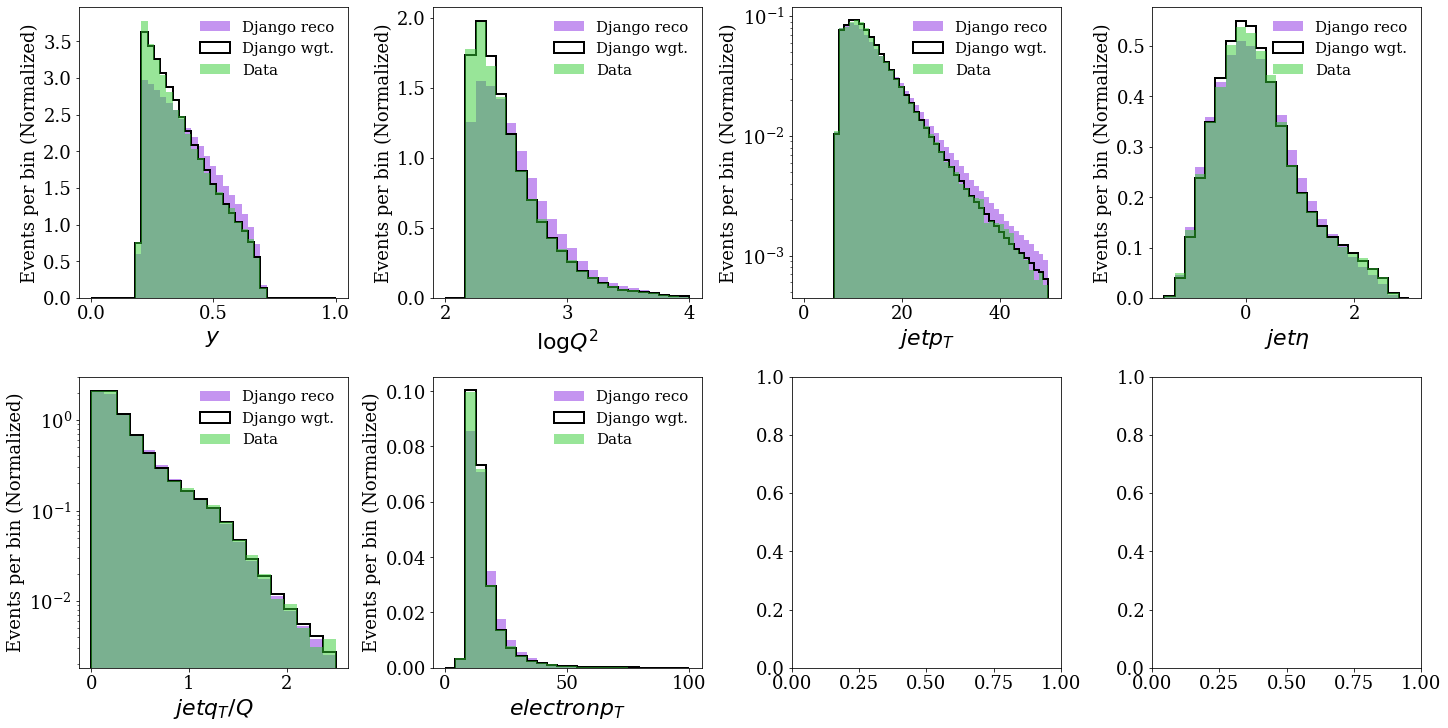

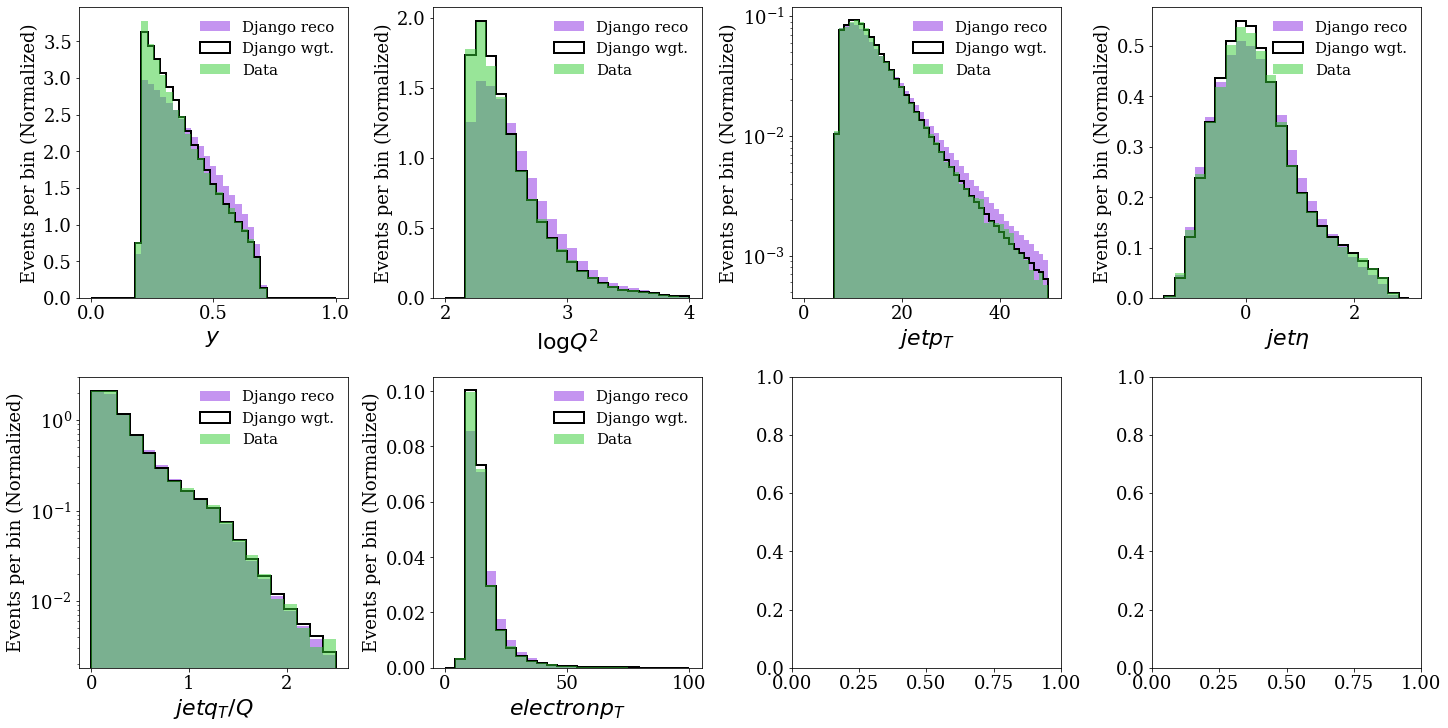

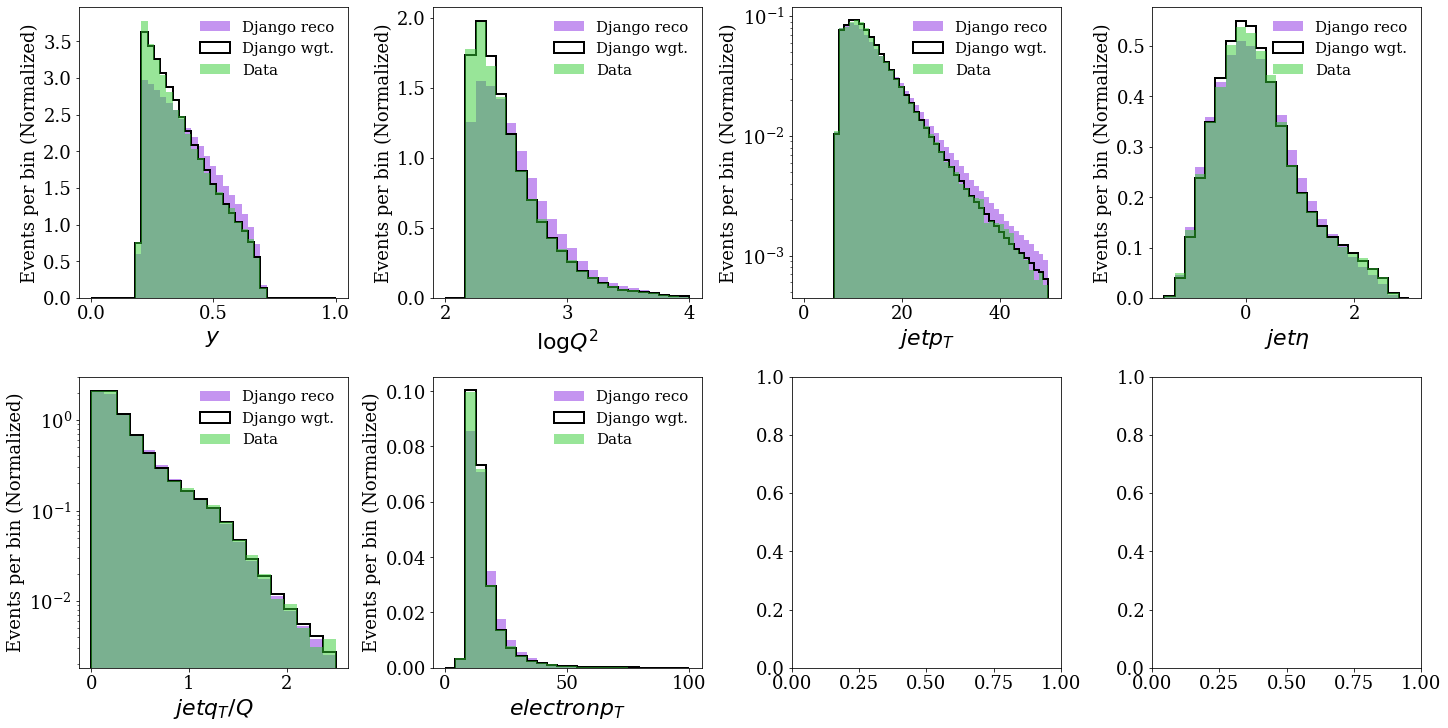

In [59]:



query = 'pass_reco==1 '
print('The query is:' , query)
label1 = r'Django reco'
label2 = r'Django wgt.'
label3 = r'Data'

color1='blueviolet'
color2='limegreen'
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['y'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,0].hist(mc_cut.query(query)['y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,0].legend(frameon=False,loc='best')

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['logQ2'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,1].hist(mc_cut.query(query)['logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[0,1].legend(frameon=False,loc='best')

    
    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$ jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['jet_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,2].hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[0,2].set_yscale('log')
    #ax[0,2].set_xscale('log')
    ax[0,2].legend(frameon=False,loc='best')

    
    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet \eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['jet_eta'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[0,3].hist(mc_cut.query(query)['jet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    ax[0,3].legend(frameon=False,loc='best')
    

    bins = np.linspace(0,2.5,20)
    
    ax[1,0].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,0].hist(mc_cut.query(query)['jet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2,color=color2)
    
    ax[1,0].legend(frameon=False,loc='best')
    ax[1,0].set_yscale('log')

   
    bins = np.linspace(0,100,25)

    ax[1,1].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['e_pt'], bins=bins, label=label1, **plot_style_2,color=color1)
    ax[1,1].hist(mc_cut.query(query)['e_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2, color=color2)
    
    ax[1,1].legend(frameon=False,loc='best')
    
    #plt.tight_layout()


## Plot unfolded results

The query is: pass_reco==1
ITERATION: 1
ITERATION: 2
ITERATION: 3
ITERATION: 4


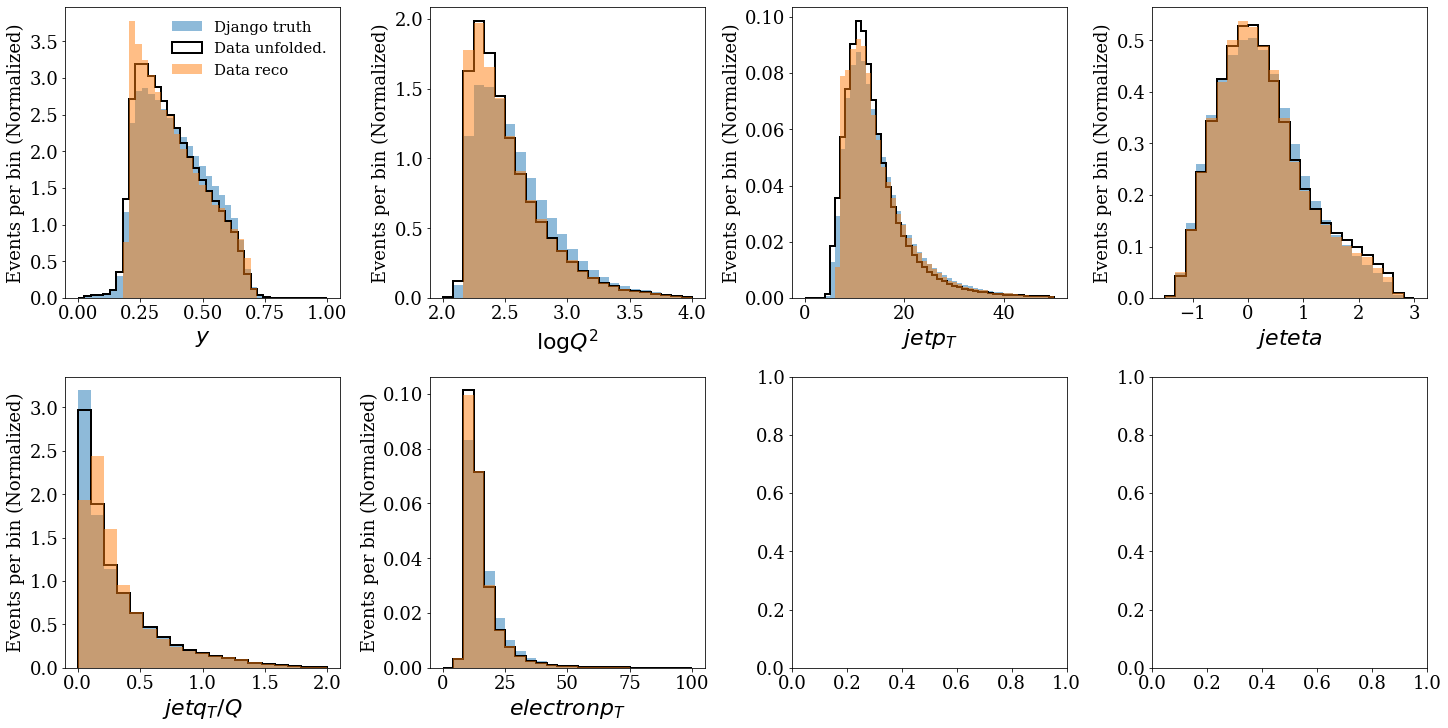

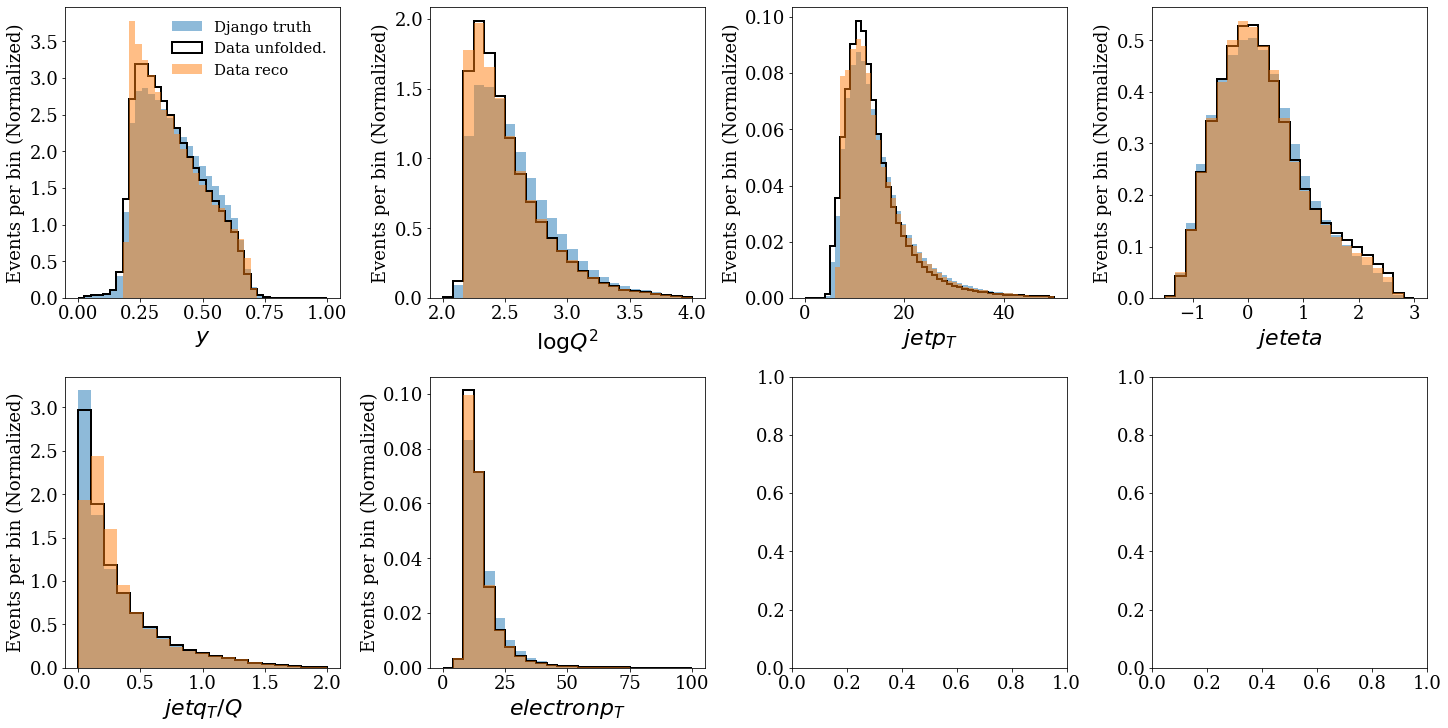

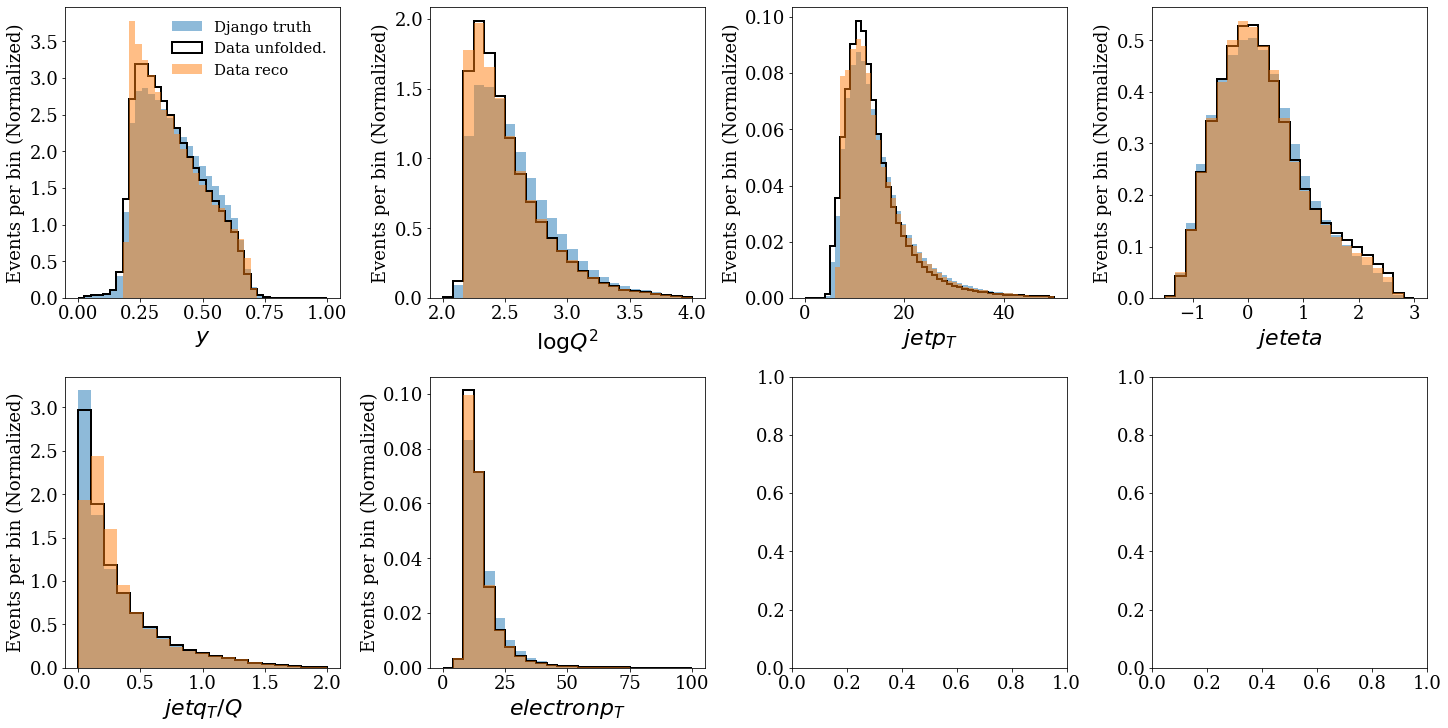

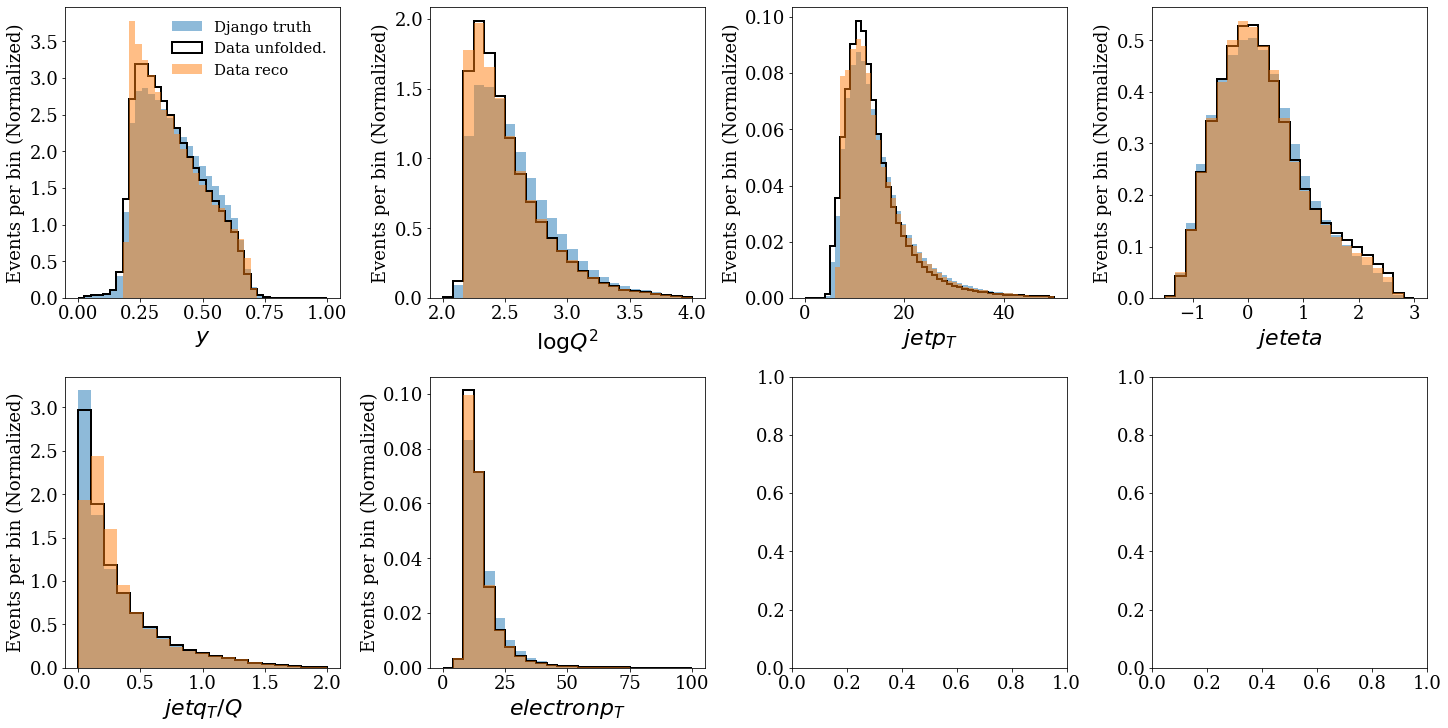

In [60]:
#event_selection = 'gen_y>0.2 and gen_y<0.7 and gen_Q2>150'
##track_selection = 'gen_track_pt>0.2'
#jet_selection    = 'gen_track_jetpt>15'
#query = 'pass_reco==1 and ' + event_selection + ' and ' + track_selection + ' and ' + jet_selection

query = 'pass_reco==1'
print('The query is:' , query)

label1 = r'Django truth'
label2 = r'Data unfolded.'
label3 = r'Data reco'

for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(2, 5,100 )
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           4,
                           figsize=(20, 10),
                           constrained_layout=True)
    bins = np.linspace(0.0, 1.0,40 )

    ax[0,0].set_xlabel(r'$y$',fontsize=22)
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(mc_cut.query(query)['gen_y'], bins=bins, label=label1, **plot_style_2)
    ax[0,0].hist(mc_cut.query(query)['gen_y'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,0].hist(data_cut.query(query)['y'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    ax[0,0].legend(frameon=False)

    bins = np.linspace(2, 4,25 )

    ax[0,1].set_xlabel(r'$\log Q^{2}$',fontsize=22)
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'], bins=bins, label=label1, **plot_style_2)
    ax[0,1].hist(mc_cut.query(query)['gen_logQ2'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,1].hist(data_cut.query(query)['logQ2'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    

    
    bins = np.linspace(0,50,50 )

    ax[0,2].set_xlabel(r'$jet p_{T} $',fontsize=22)
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'], bins=bins, label=label1, **plot_style_2)
    ax[0,2].hist(mc_cut.query(query)['genjet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,2].hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    bins = np.linspace(0,2,20 )

    
    ax[1,0].set_xlabel(r'$jet q_{T}/Q $',fontsize=22)
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(mc_cut.query(query)['genjet_qtnorm'], bins=bins, label=label1, **plot_style_2)
    ax[1,0].hist(mc_cut.query(query)['genjet_qtnorm'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,0].hist(data_cut.query(query)['jet_qtnorm'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    
    #ax[1,1].set_yscale('log')

    bins = np.linspace(-1.5,3,25 )

    ax[0,3].set_xlabel(r'$jet eta $',fontsize=22)
    ax[0,3].set_ylabel('Events per bin (Normalized)')
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'], bins=bins, label=label1, **plot_style_2)
    ax[0,3].hist(mc_cut.query(query)['genjet_eta'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[0,3].hist(data_cut.query(query)['jet_eta'],
               bins=bins,
               label=label3,
               **plot_style_2)
    
    
    bins = np.linspace(0,100,25)

    ax[1,1].set_xlabel(r'$electron p_{T} $',fontsize=22)
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(mc_cut.query(query)['gene_pt'], bins=bins, label=label1, **plot_style_2)
    ax[1,1].hist(mc_cut.query(query)['gene_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_truth'],
               label=label2,
               **plot_style_1)

    ax[1,1].hist(data_cut.query(query)['e_pt'],
               bins=bins,
               label=label3,
               **plot_style_2)
    

## Jet pT spectrum data reco vs MC reco

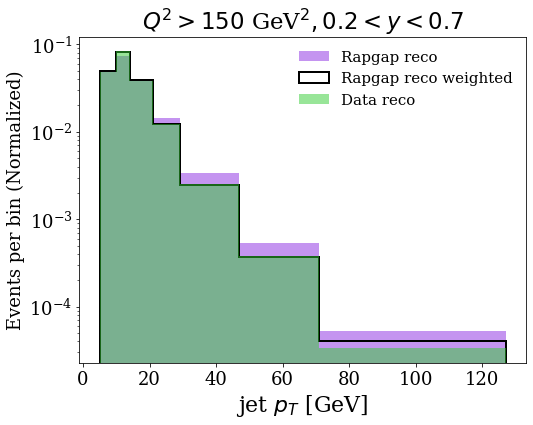

In [93]:
fig = plt.figure(figsize=(8,6))
query = 'pass_reco==1'
bins = np.array([5,10,14,21,29,47,71,127])

#plt.set_xlabel(r'$ jet p_{T} $',fontsize=22)
#plt.set_ylabel('Events per bin (Normalized)')
plt.hist(mc_cut.query(query)['jet_pt'], bins=bins, label='Rapgap reco', **plot_style_2,color=color1)
plt.hist(mc_cut.query(query)['jet_pt'],
               bins=bins,
               weights=mc_cut.query(query)['weight_reco'],
               label='Rapgap reco weighted',
               **plot_style_1)

plt.hist(data_cut.query(query)['jet_pt'],
               bins=bins,
               label='Data reco',
               **plot_style_2,color=color2)
plt.legend()
plt.yscale('log')
plt.title(r'$Q^{2}>150$ GeV$^{2}, 0.2<y<0.7$')

plt.xlabel(r'jet $p_{T} $ [GeV]',fontsize=22)
plt.ylabel('Events per bin (Normalized)')
#plt.xscale('log')
plt.legend(frameon=False,loc='best')
fig.savefig('figures/jetpt_reco.png'%i)  




## Plot data, and unfolded results and MC truth

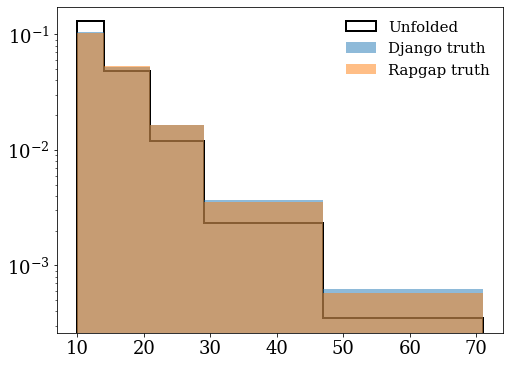

In [80]:
fig = plt.figure(figsize=(8,6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
#bins = np.logspace(np.log10(15),np.log10(100),8)
bins = np.array([10,14,21,29,47,71])

#plt.hist(data['jet_pt'],bins=bins,label='Data (reco)',**plot_style_2)
#num,x,_ = plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label='Rapgap Truth',**plot_style_2)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)
plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Django truth',**plot_style_2)
plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Rapgap truth',**plot_style_2)


plt.legend()
plt.yscale('log')
#plt.xscale('log')

plt.show()

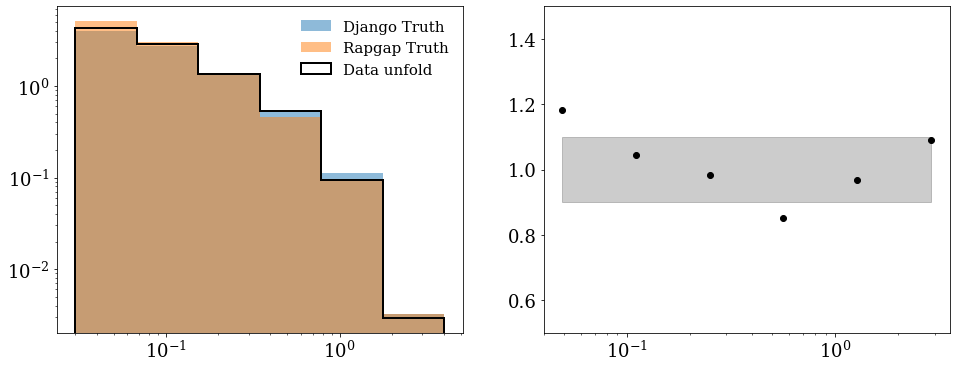

In [91]:
fig,ax = plt.subplots(1,2,figsize=(16, 6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
#bins = np.linspace(0,3,6)
bins = np.logspace(np.log10(0.03),np.log10(4),7)

ax[0].hist(altmc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Django Truth',**plot_style_2)

num,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,label='Rapgap Truth',**plot_style_2)

den,x,_ = ax[0].hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Data unfold',**plot_style_1)
x= (x[1:] + x[:-1])/2.0
ratio = np.true_divide(num,den)

ax[0].legend()
ax[0].set_yscale('log')

ax[0].set_xscale('log')
ax[1].set_xscale('log')


ax[1].plot(x,ratio,'o',color='black')
ax[1].fill_between(x, 0.9,1.1,alpha=0.2,color='black')
ax[1].set_ylim([0.5,1.5])

plt.show()

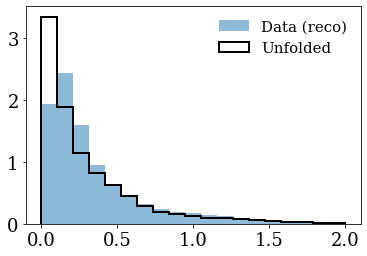

In [81]:
fig = plt.figure(figsize=(8,6))

cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
bins = np.linspace(0,2,20)
plt.hist(data['jet_qtnorm'],bins=bins,label='Data (reco)',**plot_style_2)
#num,x,_ = plt.hist(altmc_cut.query(cut)['genjet_pt'],bins=bins,label='Rapgap Truth',**plot_style_2)
den,x,_ = plt.hist(mc_cut.query(cut)['genjet_qtnorm'],bins=bins,weights=mc_cut.query(cut)['weight_truth'],label = 'Unfolded',**plot_style_1)
#den,x,_ = plt.hist(mc_cut.query(cut)['genjet_pt'],bins=bins,label = 'Django truth',**plot_style_1)


plt.legend()
#plt.yscale('log')
#plt.xscale('log')

plt.show()

In [82]:
#y, x  = np.histogram(df_jet['jet_pt'],bins=np.linspace(6,100,21))
cut = ' gen_Q2 > 150 and gen_y>0.2 and gen_y<0.7'
cut = cut + ' and genjet_pt>10'
bins = np.array([10,14,21,29,47,71,127])
y, x  = np.histogram(mc_cut.query(cut)['genjet_pt'],bins=bins,weights=mc_cut.query(cut)['weight_truth'])
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y/(xerr*2.0)
integral = np.sum(y)

6
6


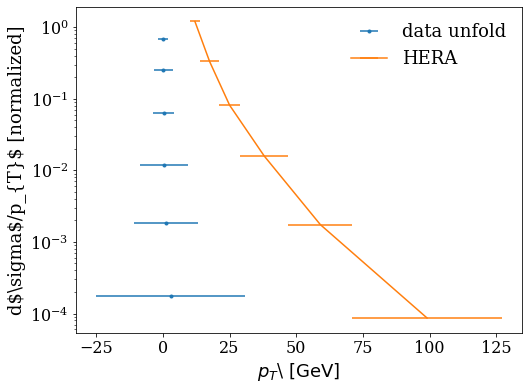

In [94]:
fig = plt.figure(figsize=(8,6))


plt.errorbar(x,y=y/integral,  xerr = xerr, fmt='.',ls='none',label='data unfold')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel(r'$p_{T}$\ $[\mathrm{GeV}]$',fontsize=18)
plt.ylabel(r'd$\sigma$/p_{T}$ [normalized]',fontsize=18)



#heray = np.array([2685, 1408,599.9,165.55,40.59,7.90, 0.873, 0.0433])
#heraxdo = np.array([6,8,10,14,21,29,47,71])
#heraxup = np.array([8,10,14,21,29,47,71,127])


heray = np.array([599.9,165.55,40.59,7.90, 0.873, 0.0433])
heraxdo = np.array([10,14,21,29,47,71])
heraxup = np.array([14,21,29,47,71,127])
heraerrx = (heraxup-heraxdo)/2.0
herax = (heraxup+heraxdo)/2.0

ratio = np.true_divide(0.005*heray,y/integral)


print(len(herax))
print(len(heray))
plt.errorbar(herax, 0.002*heray, xerr=heraerrx,label='HERA')
plt.legend(loc='best',frameon=False,fontsize=18)

plt.yscale('log')


In [ ]:
plt.plot(x,ratio,'o',color='black')

## Bootstrapping

In [ ]:
epx_0_G       = mc_cut['gene_px']
epx_0_S       = mc_cut['e_px']

epy_0_G       = mc_cut['gene_py']
epy_0_S       = mc_cut['e_py']

epz_0_G       = mc_cut['gene_pz']
epz_0_S       = mc_cut['e_pz']

jetpt_0_G       = mc_cut['genjet_pt']
jetpt_0_S       = mc_cut['jet_pt']


jetphi_0_G       = mc_cut['genjet_phi']
jetphi_0_S       = mc_cut['jet_phi']


jeteta_0_G       = mc_cut['genjet_eta']
jeteta_0_S       = mc_cut['jet_eta']

jetdphi_0_G       = mc_cut['genjet_dphi']
jetdphi_0_S       = mc_cut['jet_dphi']


jetqt_0_G       = mc_cut['genjet_qtnorm']
jetqt_0_S       = mc_cut['jet_qtnorm']


In [ ]:
theta0_G=np.c_[(epx_0_G, epy_0_G, epz_0_G,  jetpt_0_G, jeteta_0_G, jetphi_0_G, jetdphi_0_G, jetqt_0_G)]
theta0_S=np.c_[(epx_0_S, epy_0_S, epz_0_S,  jetpt_0_S, jeteta_0_S, jetphi_0_S, jetdphi_0_S, jetqt_0_S)]
 

In [ ]:
pass_reco = np.array(mc_cut['pass_reco'])
pass_truth = np.array(mc_cut['pass_truth'])
theta0_S[:,0][pass_reco==0] = -10
theta0_G[:,0][pass_truth==0] = -10

In [ ]:
data_cut.head()

In [ ]:
K.clear_session()

In [ ]:
bootstraps = 50
iterations = 4 
nvariables = 8
weights = [] 

import timeit


for i in range(bootstraps):
    start = timeit.timeit()

    print ('%i th jackknifedata'%i)
    
    ## define the data input for the unfolding
    #bootstrap_data = data_cut.sample(data_cut.shape[0], replace=True)
    #add Poisson variation of total number of data events used:
    bootstrap_data = data_cut.sample(np.random.poisson(data_cut.shape[0],1)[0], replace=True)
    
    epx_unknown_S       = bootstrap_data['e_px']
    epy_unknown_S       = bootstrap_data['e_py']
    epz_unknown_S       = bootstrap_data['e_pz'] 
    jetpt_unknown_S     = bootstrap_data['jet_pt']
    jeteta_unknown_S    = bootstrap_data['jet_eta']
    jetphi_unknown_S    = bootstrap_data['jet_phi']
    jetdphi_unknown_S   = bootstrap_data['jet_dphi']
    jetqt_unknown_S     = bootstrap_data['jet_qtnorm']

    theta_unknown_S =np.c_[(epx_unknown_S, epy_unknown_S, epz_unknown_S, jetpt_unknown_S, jeteta_unknown_S, jetphi_unknown_S, jetdphi_unknown_S, jetqt_unknown_S)]

    
    
    num_observables = 8
    i_weight, _ = multifold(num_observables=num_observables,
                       iterations=iterations,
                       theta0_G=theta0_G,
                       theta0_S=theta0_S,
                       theta_unknown_S= theta_unknown_S,
                       verbose =0
                      )
    
    
    
    weights.append(i_weight)
    end = timeit.timeit()
    print(end - start)


In [ ]:
print(len(weights))

In [ ]:
 for k in range(bootstraps):
    for i in range(len(weights[k])):
        print (weights[k].shape)
        print((weights[k][i, 1, :]).shape)
        print((weights[k][i, 1, :]).shape)
        print((weights[k][i, 1:2, :][0]).shape)


In [ ]:
covariance_matrices = []
for it in range(4):
    myns = []
    #bins = np.logspace(np.log10(0.01),np.log10(80),6)
    #bins = np.logspace(np.log10(0.1),np.log10(np.pi),20)
    #bins = np.array([0.0, 2.05491515, 2.45354097, 2.63853135,
    #                 2.8145858,  2.98213597, 3.14159265])

    #bins = np.linspace(0,2,10)
    bins = np.logspace(np.log10(0.001),np.log10(3),8)
    #bins = np.flip(2*np.pi - np.logspace(np.log10(np.pi),np.log10(2*np.pi),15)) 

    #bins = np.logspace(np.log(1.0),np.log10(5.0),12) -1
   # bins = np.array([0., 0.1,0.2, 0.33994032, 0.55105852  ,1.07832585,2.0])
    #bins = np.flip( 2- np.logspace(np.log10(1),np.log10(2.0),5)) 

    #bins = np.append(bins,inf)

    for k in range(len(weights)):
        n,b,_ = plt.hist(jetqt_0_G,bins=bins,weights=weights[k][it, 1, :],alpha=0.3)
        myns+=[n]
        pass
    myns = np.array(myns)
    #print(myns)
    plt.xlabel('tau1b')

    cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])
    corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

    covariance_matrices.append(corr)
    #fig, ax = plt.subplots() 
    #im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
    #                         interpolation='none')
    #fig.colorbar(im,ax=ax)

print(covariance_matrices[0])
plt.show()

#print (len(myns))
#print (len(myns[0]))

In [ ]:
for k in range(10):
    n,b,_ = plt.hist(jetqt_0_G,bins=bins,weights=weights[k][-1, 1, :],alpha=0.3)
    
plt.xscale('log')
#plt.yscale('log')

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(12,12)) 
minimo =-.40
maximo = 1.0

ax = ax.flatten()

im = ax[0].imshow(covariance_matrices[0],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[1].imshow(covariance_matrices[1],cmap='RdBu', vmin=minimo, vmax=1.0,
                             interpolation='none')
im = ax[2].imshow(covariance_matrices[2],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
im = ax[3].imshow(covariance_matrices[3],cmap='RdBu', vmin=minimo, vmax=1.0,
                  interpolation='none')
#im = ax[4].imshow(covariance_matrices[4],cmap='RdBu', vmin=minimo, vmax =1.0,
#                  interpolation='none')
#im = ax[6].imshow(covariance_matrices[5],cmap='RdBu', vmin=minimo, vmax=1.0,
#                  interpolation='none')


ax[0].set_title('iteration #0')
ax[1].set_title('iteration #1')
ax[2].set_title('iteration #2')
#ax[3].set_title('iteration #3')
#ax[4].set_title('iteration #4')
#ax[5].set_title('iteration #5')


plt.colorbar(im,ax=ax)
plt.show()

In [ ]:
from numpy.linalg import inv
x = [] 
rhos= []
for it in range(4): #iterations
    temp = []
    cov = np.matrix(covariance_matrices[it])
    inversecov = inv(cov)
    for i in range(cov.shape[0]):
         if(cov[i,i]*inversecov[i,i]!=0):
            temp.append( np.sqrt(1- 1.0/(cov[i,i]*inversecov[i,i])))
    rho_it = np.average(temp)
    rhos.append(rho_it)
    x.append(it+1)
    print (rho_it)
print (x)
print (rhos)

In [ ]:
np.logspace(np.log10(0.01),np.log10(3),6)

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(x,rhos,'-o')
plt.xlabel('Number of Multifold iterations',fontsize=20)
plt.ylabel('Mean global-correlation coefficient',fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

In [ ]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns[0]))] for j in range(len(myns[0]))])

In [ ]:
fig, ax = plt.subplots() 
im = ax.imshow(corr,cmap='RdBu', vmin=0.0, vmax=1.0,
                             interpolation='none')
fig.colorbar(im,ax=ax)
plt.show()